In [1]:
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import ascii
from scipy.interpolate import interp1d
import cv2 as cv
from astropy import wcs
from astropy.cosmology import LambdaCDM as Cos
from scipy.stats import kde
from scipy.stats import binned_statistic_2d, binned_statistic

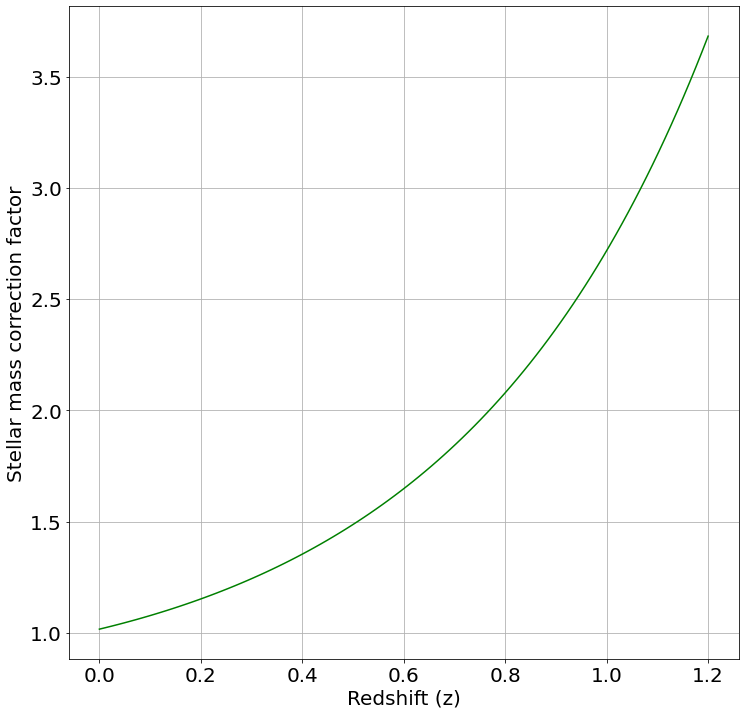

In [2]:
def mass_coefficient(z):
    return 10**((0.1934685649122839)*z**2 + 0.23392299620558993*z + 0.0069438686839181476)
plt.figure(figsize = (12, 12))
z = np.linspace(0, 1.2, 100)
plt.plot(z, mass_coefficient(z), "-g")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Redshift (z)",fontsize = 20)
plt.ylabel("Stellar mass correction factor",fontsize = 20)
plt.grid()
plt.savefig('smcf.pdf')
plt.show()

In [3]:
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
z_array = np.linspace(1e-2, 1.2, 500)
sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")

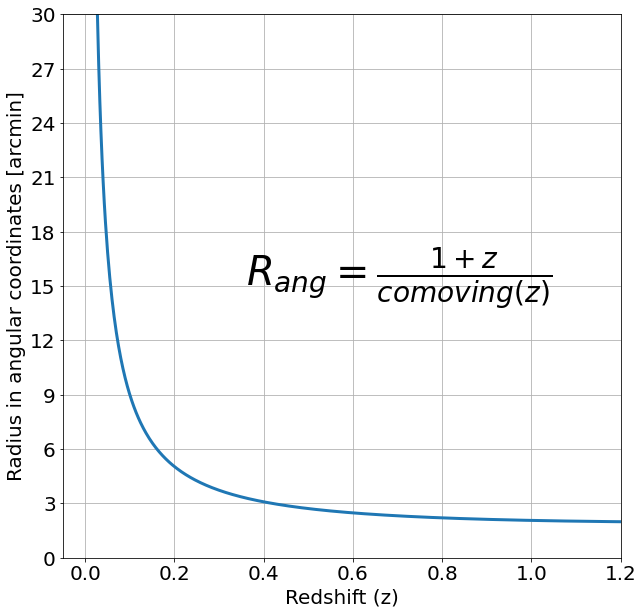

In [4]:
plt.figure(figsize = (10, 10))
plt.plot(np.linspace(0, 2, 10000), 60*(180/np.pi)*radius_threshold(np.linspace(0, 2, 10000)), "-", lw = 3)
#plt.title("Radius as a function of redshift", fontsize = 15)
plt.ylabel("Radius in angular coordinates [arcmin]", fontsize = 20)
plt.xlabel("Redshift (z)", fontsize = 20)
string = r"$R_{ang} = \frac{1+z}{comoving(z)}$"
plt.text(0.36, 15, s = string, fontsize = 40)
plt.xlim(-0.05, 1.2)
plt.ylim(0, 30)
plt.xticks(fontsize = 20)
plt.yticks(np.linspace(0, 30, 11), fontsize = 20)
plt.grid()
plt.savefig("radius.pdf")
plt.show()

In [5]:
hdul = fits.open("threshold_training_north_2.fits")  # open a FITS file
data = hdul[1].data
hdul = fits.open("threshold_training_south_2.fits")  # open a FITS file
data2 = hdul[1].data

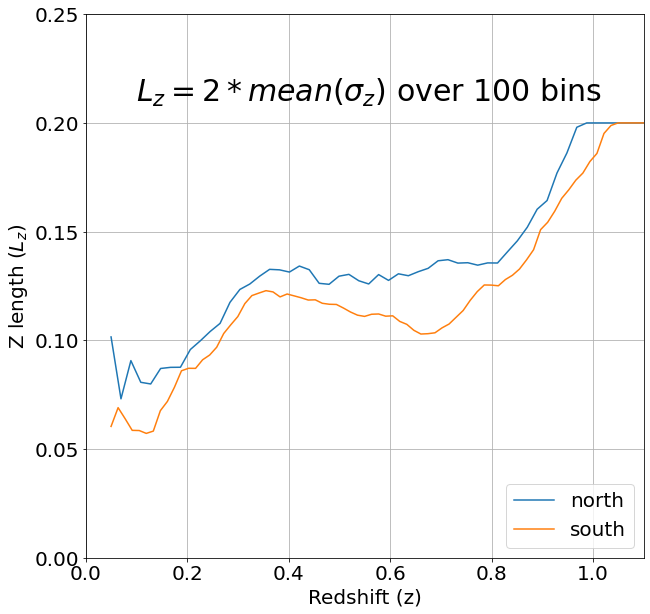

In [6]:
plt.figure(figsize = (10, 10))
plt.plot(data.z, 2*data.sigma_z_threshold, "-", label = "north")
plt.plot(data2.z, 2*data2.sigma_z_threshold, "-", label = "south")
plt.xlim(0, 1.1)
plt.ylim(0, 0.25)
#plt.title("Interpolated Z half length as a function of redshift",  fontsize = 12)
plt.ylabel("Z length ($L_z$)",  fontsize = 20)
plt.xlabel("Redshift (z)",  fontsize = 20)
string = r"$L_z = 2* mean(\sigma_z)$ over 100 bins"
plt.text(0.1, 0.21, s = string, fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = "lower right", fontsize = 20)
plt.grid()
plt.savefig("len_z.pdf")
plt.show()

In [7]:
hdul = fits.open("neighbor_training_north_2.fits")  # open a FITS file
data = hdul[1].data

In [8]:
hdul = fits.open("neighbor_training_south_2_2.fits")  # open a FITS file
data2 = hdul[1].data

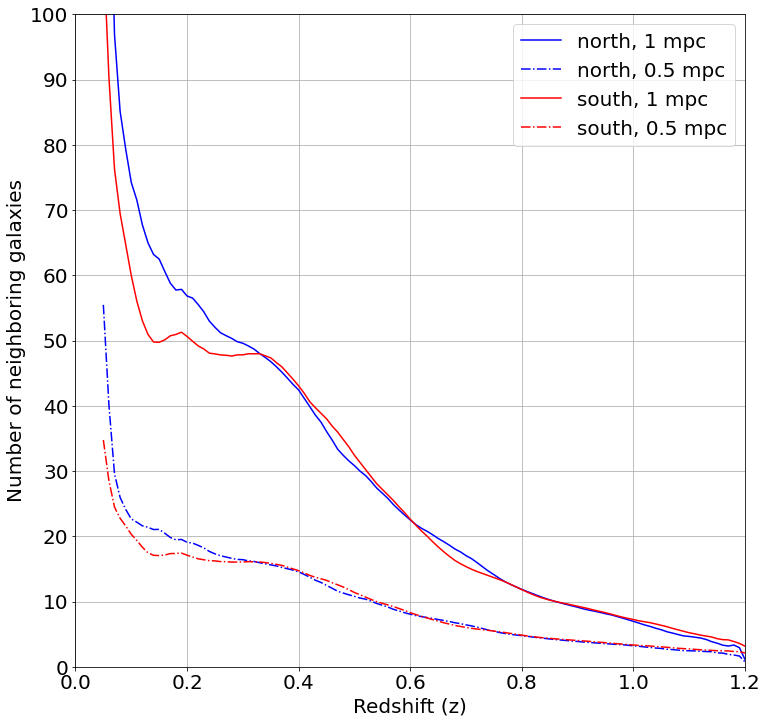

In [9]:
plt.figure(figsize = (12, 12))
plt.plot(data.z, data.neighbor_threshold1, "-b", label = "north, 1 mpc")
plt.plot(data.z, data.neighbor_threshold2, "-.b", label = "north, 0.5 mpc")
plt.plot(data2.z, data2.neighbor_threshold1, "-", color = "red", label = "south, 1 mpc")
plt.plot(data2.z, data2.neighbor_threshold2, "-.", color = "red", label = "south, 0.5 mpc")
plt.ylim(0, 100)
plt.xlim(0, 1.2)
plt.xlabel("Redshift (z)", fontsize = 20)
plt.ylabel("Number of neighboring galaxies", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(np.linspace(0, 100, 11), fontsize = 20)
plt.legend(fontsize = 20)
plt.grid()
plt.savefig("threshold.pdf")
plt.show()

In [11]:
clumpr = Table.read("DESI_clusters_final_2023_full_speczs.fits").to_pandas()

In [18]:
data = ascii.read("Data/clusters.dat").to_pandas()

In [19]:
columns = ["ID",
    "RA",
    "DEC",
    "zphot",
    "zspec",
    "den",
    "Bkg",
    "RAMdeg",
    "DEMdeg",
    "Ng",
    "Ltot",
    "M500",
    "R500",
    "Richness",
    "RABdeg",
    "DEBdeg",
    "zphotB",
    "e_zphotB",
    "zspecB",
    "gmag",
    "rmag",
    "zmag",
    "W1mag",
    "W2mag",
    "e_gmag",
    "e_rmag",
    "e_zmag",
    "e_W1mag",
    "e_W2mag",
    "gMag",
    "rMag",
    "zMag",
    "W1Mag",
    "W2Mag",
    "Mass",
    "b_Mass",
    "B_Mass"]
data.columns = columns

In [20]:
data["edge_mask"] = np.load("zou_mask.npy")

In [21]:
zou = data[data.edge_mask == 1]

In [22]:
redmapper_T = Table.read("Data/redmapper_dr8_public_v6.3_catalog.fits.gz")

In [23]:
redmapper = redmapper_T["ID","NAME","RA","DEC","Z_LAMBDA","Z_LAMBDA_ERR","LAMBDA","LAMBDA_ERR","S","Z_SPEC","OBJID","IMAG","IMAG_ERR"].to_pandas()

In [24]:
clumpr_zs = clumpr[np.logical_and(clumpr.spec_z > 0.1, clumpr.spec_z_err < 0.01)].copy()

In [25]:
zou_zs = zou[zou.zspec > 0]

In [26]:
np.abs(clumpr_zs.z_median_central - clumpr_zs.z_average_no_wt).max()

0.252014910536153

In [21]:
redmapper.Z_SPEC

0        0.090807
1       -1.000000
2       -1.000000
3       -1.000000
4        0.228309
           ...   
26106    0.568342
26107   -1.000000
26108   -1.000000
26109   -1.000000
26110   -1.000000
Name: Z_SPEC, Length: 26111, dtype: float32

In [22]:
red_zs = redmapper[redmapper.Z_SPEC > 0]

In [23]:
def pplusone(array):
    return np.percentile(array, q = 84.1)
def pminusone(array):
    return np.percentile(array, q = 15.9)

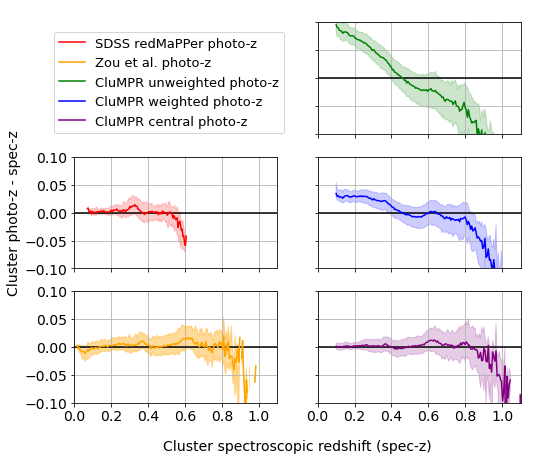

In [24]:
fig, ax = plt.subplots(figsize = (8, 7), nrows = 3, ncols = 2, sharex='all', sharey='all')
plt.ylim(-0.1, 0.1)
plt.xlim(0, 1.1)

#plt.xlabel("Cluster spectroscopic redshift (spec-z)", fontsize = 10)
#plt.ylabel("Cluster photo-z - spec-z", fontsize = 10)

ax0 = fig.add_subplot(1, 1, 1, frameon=False)    # The big subplot
ax0.set_xlabel("Cluster spectroscopic redshift (spec-z)", fontsize = 14, labelpad = 20)
ax0.set_ylabel("Cluster photo-z - spec-z", fontsize = 14, labelpad = 30)
ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')

ax0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Redmapper
stats, bin_edges, bin_num = binned_statistic(red_zs.Z_SPEC, red_zs.Z_LAMBDA - red_zs.Z_SPEC, statistic = "median", bins = 200)
stats2, bin_edges, bin_num = binned_statistic(red_zs.Z_SPEC, red_zs.Z_LAMBDA - red_zs.Z_SPEC, statistic = pplusone, bins = 200)
stats3, bin_edges, bin_num = binned_statistic(red_zs.Z_SPEC, red_zs.Z_LAMBDA - red_zs.Z_SPEC, statistic = pminusone, bins = 200)
ax[1, 0].axhline(0, color = "k")
handle1, = ax[1, 0].plot(np.linspace(red_zs.Z_SPEC.min(), red_zs.Z_SPEC.max(), 200)[:-75], stats[:-75], "-r", label = "Redmapper photo-z")
ax[1, 0].fill_between(np.linspace(red_zs.Z_SPEC.min(), red_zs.Z_SPEC.max(), 200)[:-75], stats2[:-75], stats3[:-75], color = "red", alpha = 0.2)
ax[1, 0].grid()
ax[1, 0].tick_params(axis='both',labelsize=14)

#Zou
stats, bin_edges, bin_num = binned_statistic(zou_zs.zspec, zou_zs.zphot - zou_zs.zspec, statistic = "median", bins = 300)
stats2, bin_edges, bin_num = binned_statistic(zou_zs.zspec, zou_zs.zphot - zou_zs.zspec, statistic = pplusone, bins = 300)
stats3, bin_edges, bin_num = binned_statistic(zou_zs.zspec, zou_zs.zphot - zou_zs.zspec, statistic = pminusone, bins = 300)
ax[2, 0].axhline(0, color = "k")
handle2, = ax[2, 0].plot(np.linspace(zou_zs.zspec.min(), zou_zs.zspec.max(), 300)[:-1], stats[:-1], "-", color="orange", label = "Zou photo-z")
ax[2, 0].fill_between(np.linspace(zou_zs.zspec.min(), zou_zs.zspec.max(), 300)[:-1], stats2[:-1], stats3[:-1], color = "orange", alpha = 0.4)
ax[2, 0].grid()
ax[2, 0].tick_params(axis='both',labelsize=14)

#CluMPR unweighted
stats, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_average_no_wt - clumpr_zs.spec_z, statistic = "median", bins = 300)
stats2, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_average_no_wt - clumpr_zs.spec_z, statistic = pplusone, bins = 300)
stats3, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_average_no_wt - clumpr_zs.spec_z, statistic = pminusone, bins = 300)
ax[0, 1].axhline(0, color = "k")
handle3, = ax[0, 1].plot(np.linspace(clumpr_zs.spec_z.min(), clumpr_zs.spec_z.max(), 300)[:-1], stats[:-1], "-g", label = "Clumper unweighted photo-z")
ax[0, 1].fill_between(np.linspace(clumpr_zs.spec_z.min(), clumpr_zs.spec_z.max(), 300)[:-1], stats2[:-1], stats3[:-1], color = "green", alpha = 0.2)
ax[0, 1].grid()
ax[0, 1].tick_params(axis='both',labelsize=14)

#CluMPR weighted
stats, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_average_mass_prob - clumpr_zs.spec_z, statistic = "median", bins = 300)
stats2, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_average_mass_prob - clumpr_zs.spec_z, statistic = pplusone, bins = 300)
stats3, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_average_mass_prob - clumpr_zs.spec_z, statistic = pminusone, bins = 300)
ax[1, 1].axhline(0, color = "k")
handle4, = ax[1, 1].plot(np.linspace(clumpr_zs.spec_z.min(), clumpr_zs.spec_z.max(), 300)[:-1], stats[:-1], "-b", label = "Clumper weighted photo-z")
ax[1, 1].fill_between(np.linspace(clumpr_zs.spec_z.min(), clumpr_zs.spec_z.max(), 300)[:-1], stats2[:-1], stats3[:-1], color = "blue", alpha = 0.2)
ax[1, 1].grid()
ax[1, 1].tick_params(axis='both',labelsize=14)

#CluMPR central
stats, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_median_central - clumpr_zs.spec_z, statistic = "median", bins = 300)
stats2, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_median_central - clumpr_zs.spec_z, statistic = pplusone, bins = 300)
stats3, bin_edges, bin_num = binned_statistic(clumpr_zs.spec_z, clumpr_zs.z_median_central - clumpr_zs.spec_z, statistic = pminusone, bins = 300)
ax[2, 1].axhline(0, color = "k")
handle5, = ax[2, 1].plot(np.linspace(clumpr_zs.spec_z.min(), clumpr_zs.spec_z.max(), 300)[:-1], stats[:-1], "-", color="purple", label = "Clumper central photo-z")
ax[2, 1].fill_between(np.linspace(clumpr_zs.spec_z.min(), clumpr_zs.spec_z.max(), 300)[:-1], stats2[:-1], stats3[:-1], color = "purple", alpha = 0.2)
ax[2, 1].grid()
ax[2, 1].tick_params(axis='both',labelsize=14)

ax[0, 0].set_visible(False)
#fig.legend(loc = (0.1, 0.75))
fig.legend(handles = [handle1,handle2,handle3,handle4,handle5], labels = ["SDSS redMaPPer photo-z", "Zou et al. photo-z", "CluMPR unweighted photo-z", "CluMPR weighted photo-z", "CluMPR central photo-z"], loc = (0.1, 0.71), fontsize = 13) 
plt.savefig("residuals.pdf")
plt.show()

In [12]:
len(clumpr)

309115

In [13]:
H_uneq, xedges, yedges = np.histogram2d(clumpr.DEC_central, (clumpr.RA_central-300)%360, bins = (np.linspace(np.min(clumpr.DEC_central), np.max(clumpr.DEC_central), 1000), np.linspace(np.min((clumpr.RA_central-300)%360), np.max((clumpr.RA_central-300)%360), 1000)))

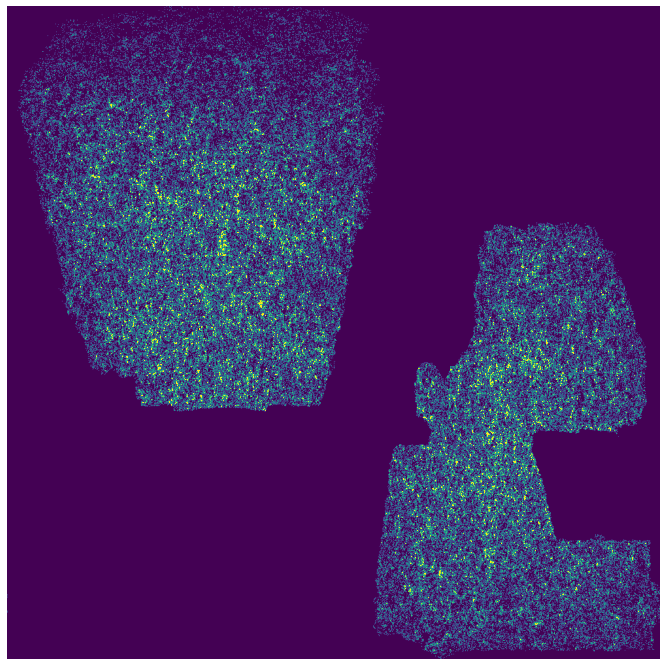

In [14]:
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq, vmax = 3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axis("off")
#plt.title("Density of clusters found on the sky", fontsize = 16)
plt.savefig("sky.pdf")
plt.show()

In [15]:
len(clumpr)

309115

In [16]:
clumpr.columns

Index(['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',
       'z_average_prob', 'z_average_mass_prob', 'z_std_central',
       'z_stde_no_wt', 'z_stde_prob', 'z_stde_mass_prob', 'RELEASE', 'BRICKID',
       'OBJID', 'MASKBITS', 'gid', 'mass_central', 'cluster_mass_onempc',
       'cluster_mass_halfmpc', 'cluster_mass_tenthmpc', 'richness_onempc',
       'richness_halfmpc', 'richness_tenthmpc'],
      dtype='object')

In [20]:
np.mean(clumpr[clumpr.z_median_central < 2].z_stde_mass_prob)

0.012546164840846974

In [65]:
np.mean(clumpr[clumpr.z_median_central > 0.8].z_std_mass_prob)

0.07740193123393674

In [20]:
clumpr.sort_values("cluster_mass_onempc", ascending = False)[["RA_central", "DEC_central"]].head(60)

RA_central  DEC_central
247030  262.916375    22.866265
3095    109.398539    37.754779
34690   269.219300    40.135312
160032  343.147767     4.523542
226625  351.865118    -2.077098
119732   30.070957    27.805921
200522   39.969665    -1.571922
8661    132.744410    48.500644
25399   139.472562    51.727031
72291   213.696609    54.784308
131237    3.586243   -30.400146
113381   44.421151   -22.154941
78600   175.603264    58.534797
73955   137.712674    38.839539
70540   215.168253    39.919530
131923  332.941336    -3.829000
276677  333.407609    -8.424340
260854  350.246408    29.216867
6267    207.902007    52.104681
225106  344.657819   -13.886452
140214  221.089200     9.447583
305954   48.753697   -27.302932
135664  324.503521   -60.131666
39039   257.397317    47.531214
252356  164.249961    -3.626715
164222   76.186384   -27.992520
307495  177.398679    22.398470
170488  347.092614    -2.192169
302300    9.225326   -12.109467
190893  327.588904    -8.788423
9266    184.800888    50.909656
268371  263.100388    19.554622
18017   231.638397    54.152032
101720  126.511816     4.324955
199243   48.218195     1.878807
33255   121.146211    33.085673
187436   22.968936   -13.611266
288378   71.698793   -37.063019
299142    8.039177    18.115538
275100   47.198058    -9.714837
184809  197.872970    -1.341088
232297  183.077004    27.548648
202311   43.588368   -60.868847
903     203.833722    41.001170
87104    24.354089    -8.456368
264175   12.295633   -24.678640
6266    203.160039    50.559924
266865  322.097574     1.593476
299143    4.639935    16.437758
10013   226.384527    33.213666
187435   24.293988   -10.572801
260853  350.561514    28.520936
83638   140.645048    62.608311
256477  125.015554    23.417334
264176   10.854721   -20.616964
13474   270.277202    39.868552
218458  210.484594    -5.188302
99055   244.013867     7.864287
231364   52.056627   -21.672090
35885   198.771808    51.817402

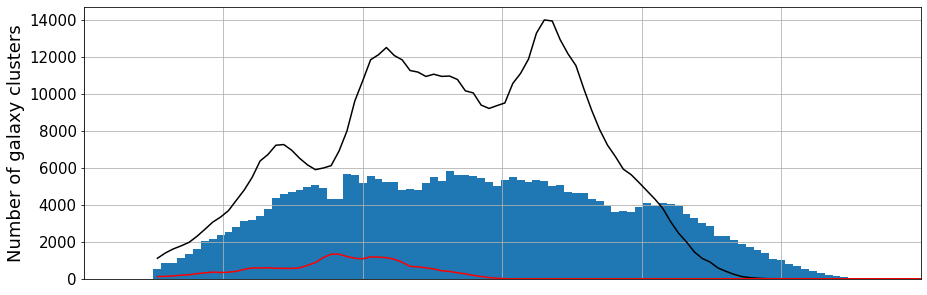

In [40]:
plt.figure(figsize = (15, 5))
n, bins, patches = plt.hist(clumpr.z_median_central, bins = 100)
zou_hist, _ = np.histogram(zou.zphot, bins = bins)
red_hist, _ = np.histogram(redmapper.Z_LAMBDA, bins = bins)
plt.plot(bins[:-1] + (bins[1] - bins[0])/2, zou_hist, "-k")
plt.plot(bins[:-1] + (bins[1] - bins[0])/2, red_hist, "-r")
plt.tick_params(left = True, right = False , labelright = False, labelleft = True, labelbottom = False, bottom = False)
#plt.xlabel("Photometric redshift (z)", fontsize = 25)
plt.ylabel("Number of galaxy clusters", fontsize = 18)
#plt.title("Redshift distribution of CluMPR galaxy clusters", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(0, 1.2)
plt.grid()
plt.savefig("red_dist.pdf")
plt.show()

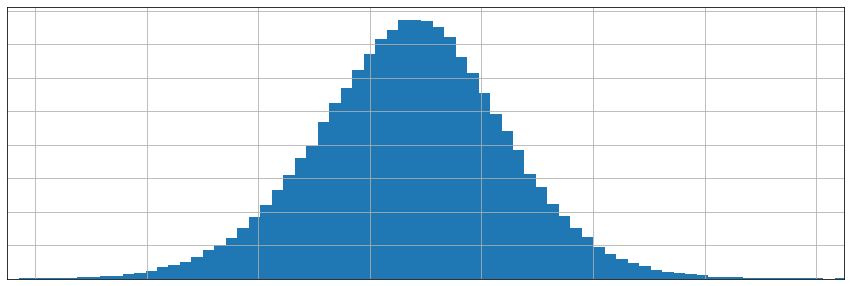

In [26]:
plt.figure(figsize = (15, 5))
plt.hist(clumpr.cluster_mass_onempc, bins = 101)
#plt.xlabel("Total cluster stellar log(mass) within 1 Mpc [log($M_\odot$)]", fontsize = 20)
plt.tick_params(left = False, right = False , labelright = False, labelleft = False, labelbottom = False, bottom = False)
#plt.ylabel("Number of galaxy clusters", fontsize = 20, labelpad = -940)
#plt.title("Stellar mass distribution of CluMPR galaxy clusters", fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.xlim(13.25, 11.75)
plt.savefig("stellar.pdf")
plt.show()

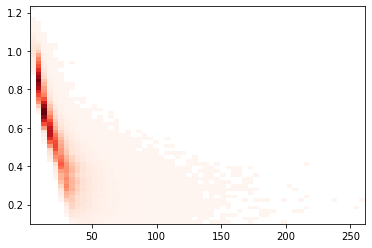

In [38]:
counts,ybins,xbins,image = plt.hist2d(clumpr.richness_onempc, clumpr.z_median_central,bins=60, cmap = "Reds", cmin = 0.5)
data_kde = np.array([clumpr.z_median_central, clumpr.richness_onempc])
k = kde.gaussian_kde(data_kde)
nbins = 200
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

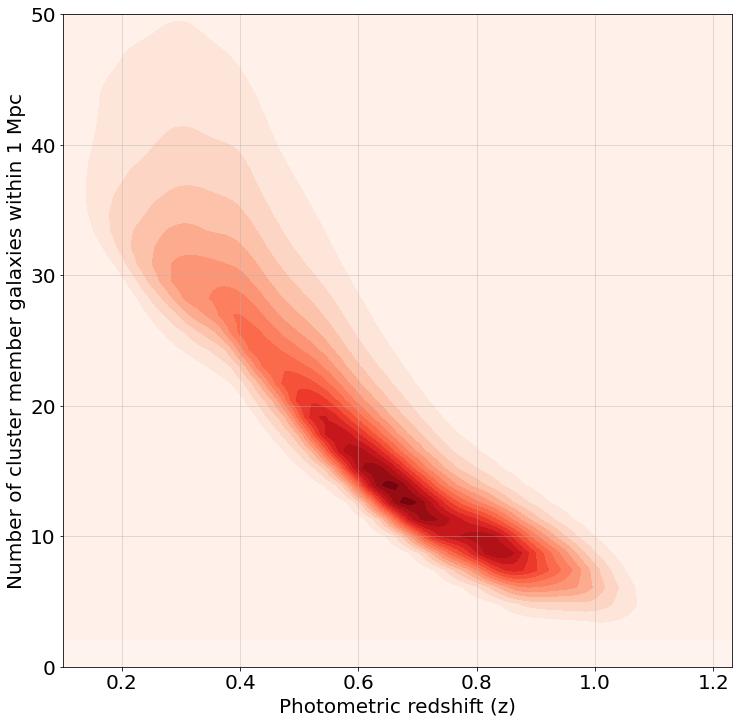

In [56]:
plt.figure(figsize = (12, 12))
#plt.style.use('dark_background')
#plt.hexbin(clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].richness_onempc, clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].cluster_mass_onempc, cmap = "Reds")
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.contourf(xi-20, yi, zi.reshape(xi.shape), extent=[xbins.min()-20,xbins.max()-20,ybins.min(),ybins.max()],cmap = "Reds", levels = 10, vmin = 1e-3)
plt.contourf(xi, yi-200, zi.reshape(xi.shape), extent=[xbins.min(),xbins.max(),ybins.min()-200,ybins.max()-200],cmap = "Reds", levels = 30, vmin = 1e-3)

plt.contourf(xi, yi, zi.reshape(xi.shape), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],cmap = "Reds", levels = 20, vmin = 1e-3)

plt.ylabel("Number of cluster member galaxies within 1 Mpc", fontsize = 20)
plt.xlabel("Photometric redshift (z)", fontsize = 20)
#plt.title("Stellar mass vs richness of CluMPR galaxy clusters between 0.5<z<0.6\n", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.xlim(6, 20)
plt.ylim(0, 50)
plt.grid(alpha = 0.5)
plt.savefig("rich_red.pdf")
plt.show()

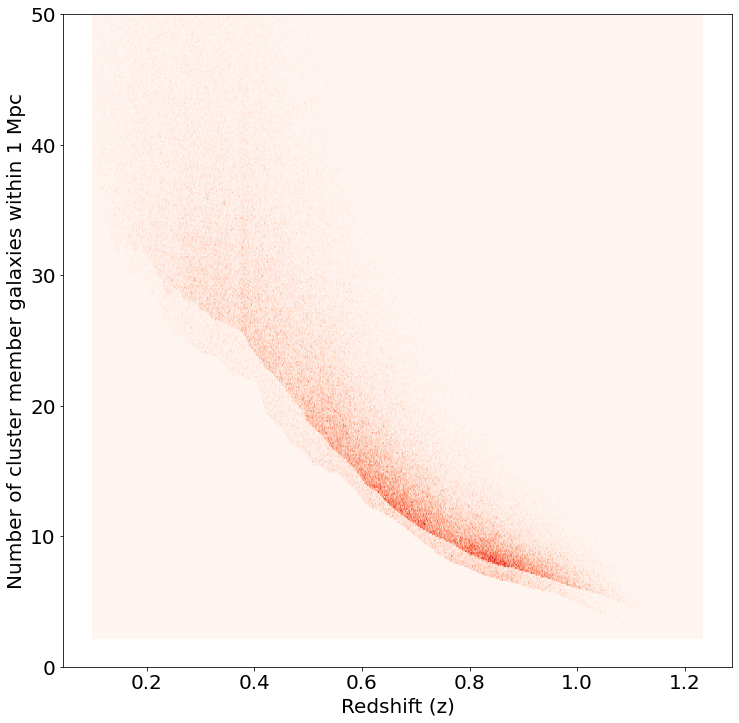

In [51]:
plt.figure(figsize = (12, 12))
plt.hexbin(clumpr.z_median_central, clumpr.richness_onempc, gridsize = (1000, 2000), cmap = "Reds")
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray", levels = 15)
plt.ylabel("Number of cluster member galaxies within 1 Mpc", fontsize = 20)
plt.xlabel("Redshift (z)", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.xlim(6, 20)
plt.ylim(0, 50)
plt.show()

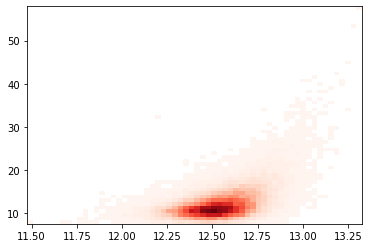

In [17]:
counts,ybins,xbins,image = plt.hist2d(clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].cluster_mass_onempc, clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].richness_onempc,bins=60, cmap = "Reds", cmin = 0.5)
data_kde = np.array([clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].richness_onempc, clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].cluster_mass_onempc])
k = kde.gaussian_kde(data_kde)
nbins = 200
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

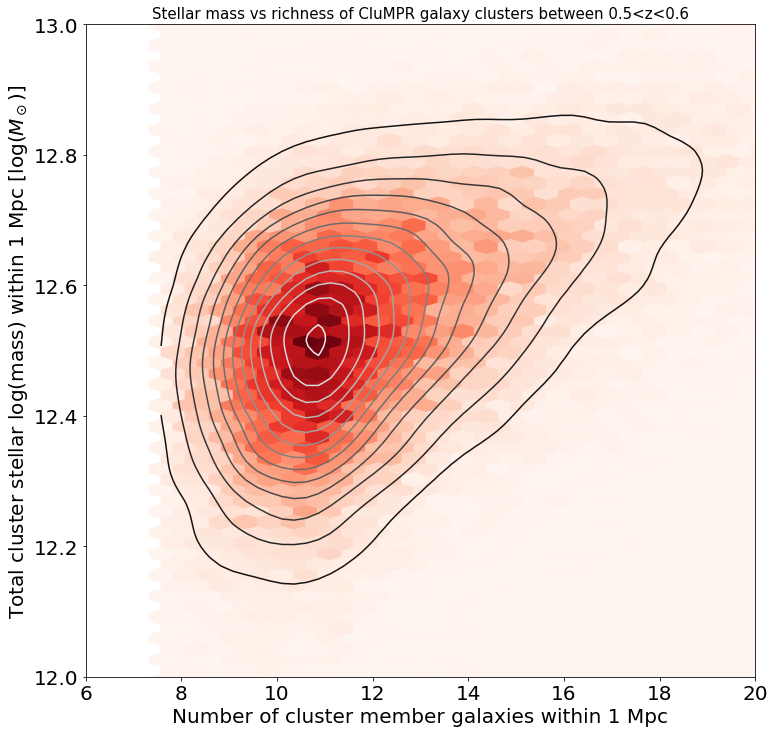

In [18]:
plt.figure(figsize = (12, 12))
plt.hexbin(clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].richness_onempc, clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].cluster_mass_onempc, cmap = "Reds")
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray", levels = 15)
plt.ylabel("Total cluster stellar log(mass) within 1 Mpc [log($M_\odot$)]", fontsize = 20)
plt.xlabel("Number of cluster member galaxies within 1 Mpc", fontsize = 20)
plt.title("Stellar mass vs richness of CluMPR galaxy clusters between 0.5<z<0.6", fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim(6, 20)
plt.ylim(12, 13)
plt.show()

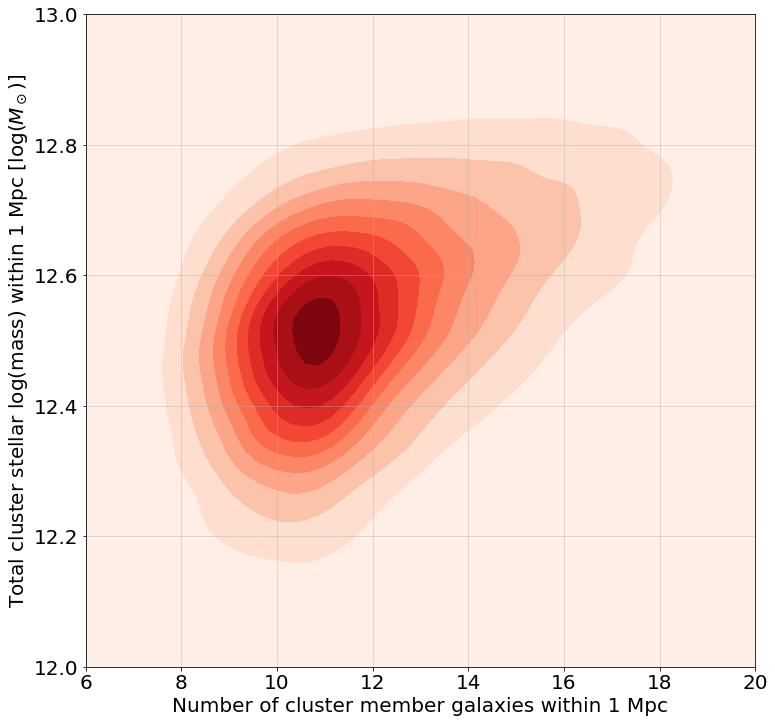

In [39]:
plt.figure(figsize = (12, 12))
#plt.style.use('dark_background')
#plt.hexbin(clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].richness_onempc, clumpr[np.logical_and(clumpr.z_median_central>0.7, clumpr.z_median_central < 0.8)].cluster_mass_onempc, cmap = "Reds")
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
plt.contourf(xi-20, yi, zi.reshape(xi.shape), extent=[xbins.min()-20,xbins.max()-20,ybins.min(),ybins.max()],cmap = "Reds", levels = 10, vmin = 1e-3)
plt.contourf(xi, yi, zi.reshape(xi.shape), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],cmap = "Reds", levels = 10, vmin = 1e-3)

plt.ylabel("Total cluster stellar log(mass) within 1 Mpc [log($M_\odot$)]", fontsize = 20)
plt.xlabel("Number of cluster member galaxies within 1 Mpc", fontsize = 20)
#plt.title("Stellar mass vs richness of CluMPR galaxy clusters between 0.5<z<0.6\n", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim(6, 20)
plt.ylim(12, 13)
plt.grid(alpha = 0.5)
plt.savefig("mass_rich.pdf")
plt.show()

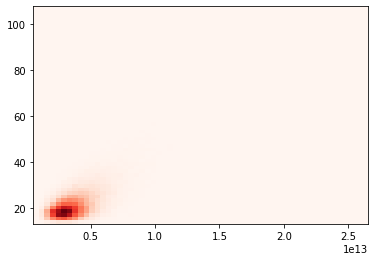

In [40]:
counts,ybins,xbins,image = plt.hist2d(10**clumpr[np.logical_and(clumpr.z_median_central>0.5, clumpr.z_median_central < 0.6)].cluster_mass_onempc, clumpr[np.logical_and(clumpr.z_median_central>0.5, clumpr.z_median_central < 0.6)].richness_onempc,bins=60, cmap = "Reds")
data_kde = np.array([clumpr[np.logical_and(clumpr.z_median_central>0.5, clumpr.z_median_central < 0.6)].richness_onempc, 10**clumpr[np.logical_and(clumpr.z_median_central>0.5, clumpr.z_median_central < 0.6)].cluster_mass_onempc])
k = kde.gaussian_kde(data_kde)
nbins = 200
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

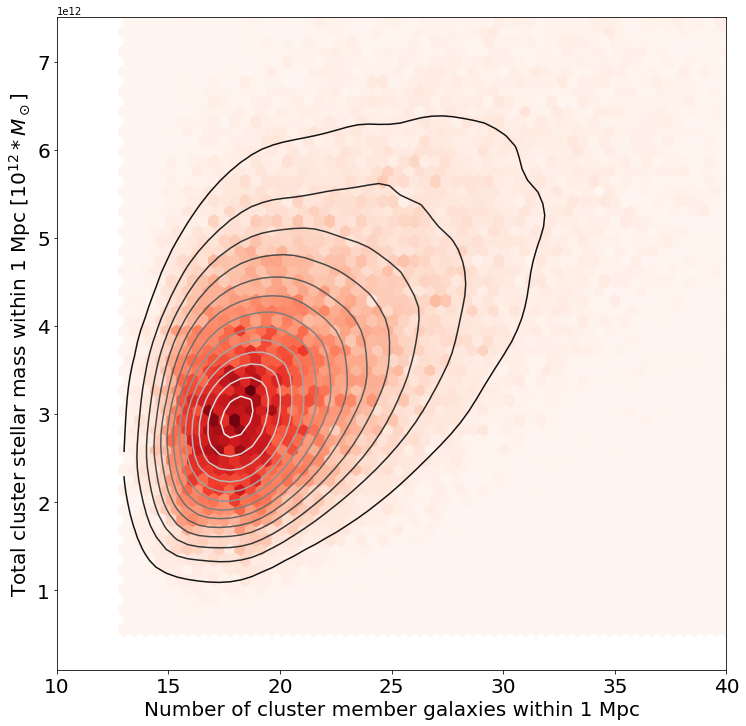

In [41]:
plt.figure(figsize = (12, 12))
plt.hexbin(clumpr[np.logical_and(clumpr.z_median_central>0.5, clumpr.z_median_central < 0.6)].richness_onempc, 10**clumpr[np.logical_and(clumpr.z_median_central>0.5, clumpr.z_median_central < 0.6)].cluster_mass_onempc, cmap = "Reds", gridsize = 200)
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray", levels = 15)
plt.ylabel("Total cluster stellar mass within 1 Mpc [$10^{12} * M_\odot$]", fontsize = 20)
plt.xlabel("Number of cluster member galaxies within 1 Mpc", fontsize = 20)
#plt.title("Stellar mass vs richness of CluMPR galaxy clusters between 0.5<z<0.6", fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim(10, 40)
plt.ylim(1e11, 0.75e13)
plt.show()

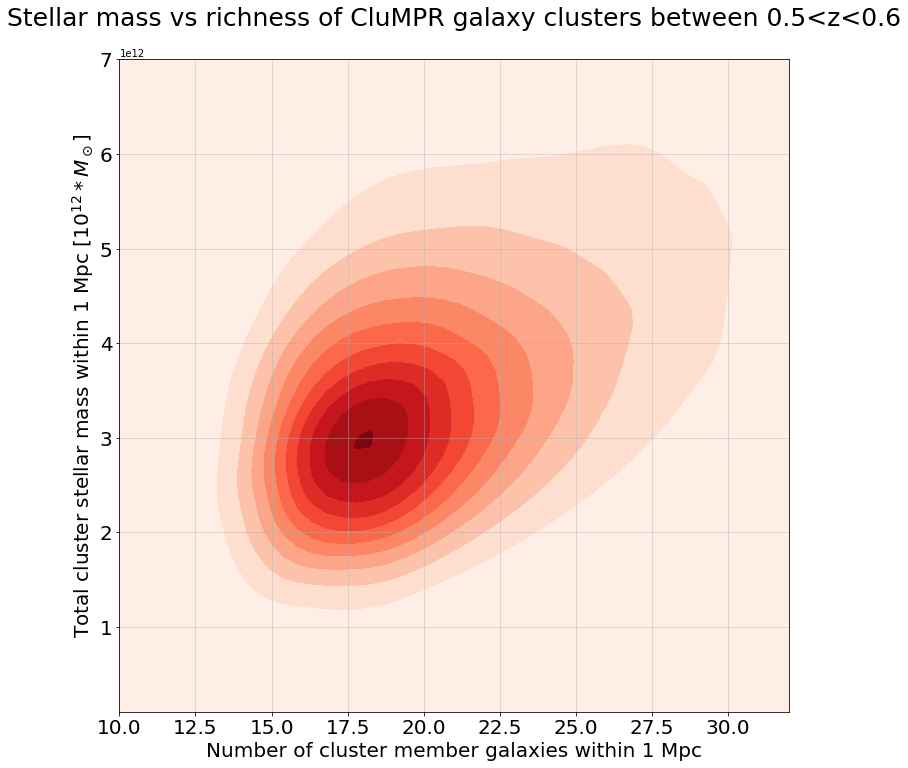

In [45]:
plt.figure(figsize = (12, 12))
plt.contourf(xi-20, yi, zi.reshape(xi.shape), extent=[xbins.min()-20,xbins.max()-20,ybins.min(),ybins.max()],cmap = "Reds", levels = 10)
plt.contourf(xi-20, yi-7e12, zi.reshape(xi.shape), extent=[xbins.min()-20,xbins.max()-20,ybins.min()-7e12,ybins.max()-7e12],cmap = "Reds", levels = 10)

plt.contourf(xi, yi, zi.reshape(xi.shape), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],cmap = "Reds", levels = 10)
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray", levels = 15)
plt.ylabel("Total cluster stellar mass within 1 Mpc [$10^{12} * M_\odot$]", fontsize = 20)
plt.xlabel("Number of cluster member galaxies within 1 Mpc", fontsize = 20)
#plt.title("Stellar mass vs richness of CluMPR galaxy clusters between 0.5<z<0.6", fontsize = 15)
plt.title("Stellar mass vs richness of CluMPR galaxy clusters between 0.5<z<0.6\n", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(alpha = 0.5)
plt.xlim(10, 32)
plt.ylim(1e11, 0.7e13)
plt.show()

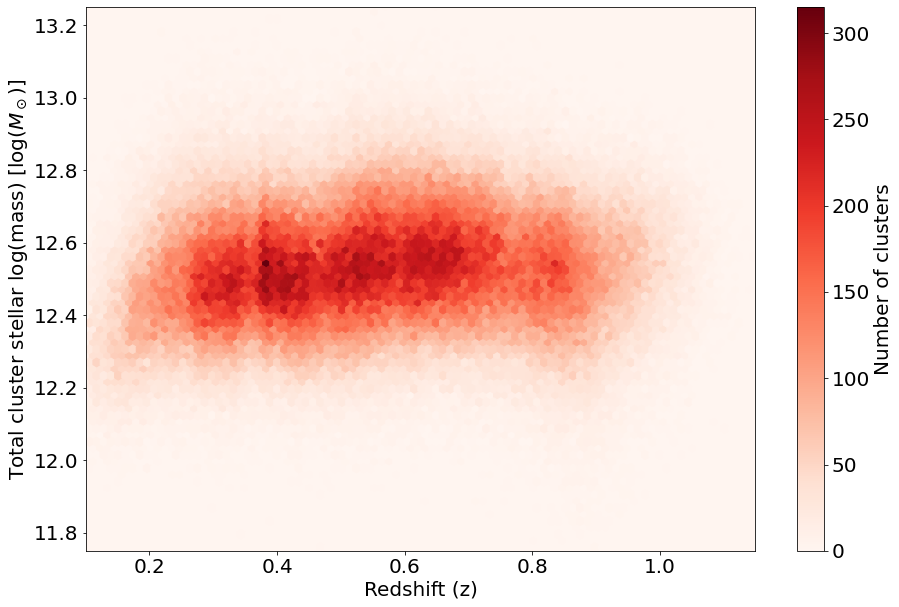

In [46]:
plt.figure(figsize = (15, 10))
plt.hexbin(clumpr.z_median_central, clumpr.cluster_mass_onempc, cmap = "Reds")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 
cbar.set_label("Number of clusters", fontsize=20) 
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 20)
plt.xlabel("Redshift (z)", fontsize = 20)
#plt.title("Stellar mass distribution of CluMPR galaxy clusters", fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim(0.1, 1.15)
plt.ylim(11.75, 13.25)
plt.show()

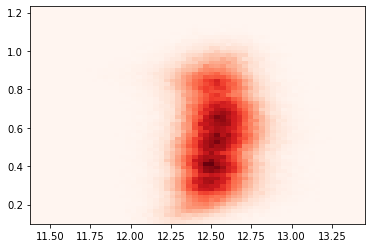

In [27]:
counts,ybins,xbins,image = plt.hist2d(clumpr[~clumpr.cluster_mass_onempc.isna()].cluster_mass_onempc, clumpr[~clumpr.cluster_mass_onempc.isna()].z_median_central,bins=60, cmap = "Reds")
data_kde = np.array([clumpr[~clumpr.cluster_mass_onempc.isna()].z_median_central, clumpr[~clumpr.cluster_mass_onempc.isna()].cluster_mass_onempc])
k = kde.gaussian_kde(data_kde)
nbins = 100
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

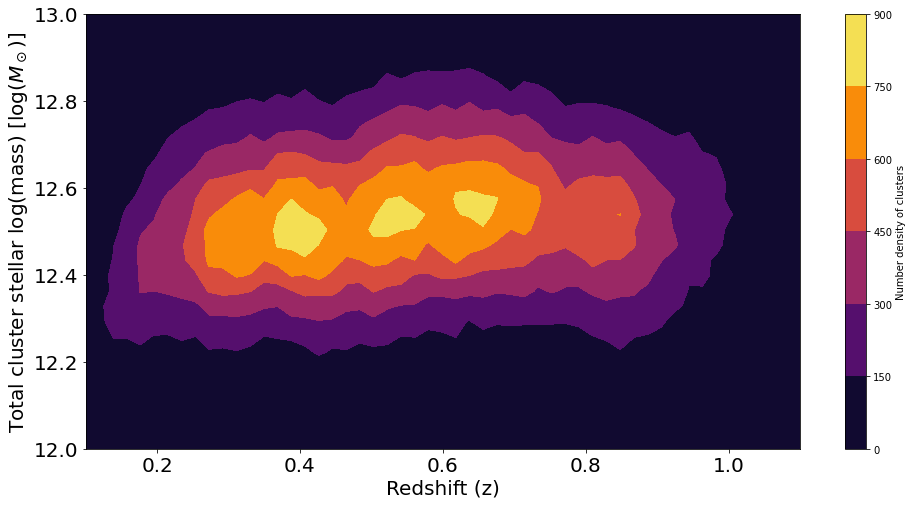

In [28]:
plt.figure(figsize = (16, 8))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 20)
plt.xlabel("Redshift (z)", fontsize = 20)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],cmap = "inferno", vmin = 1)
plt.colorbar(label = "Number density of clusters")
plt.xlim(0.1, 1.1)
plt.ylim(12, 13)
plt.show()

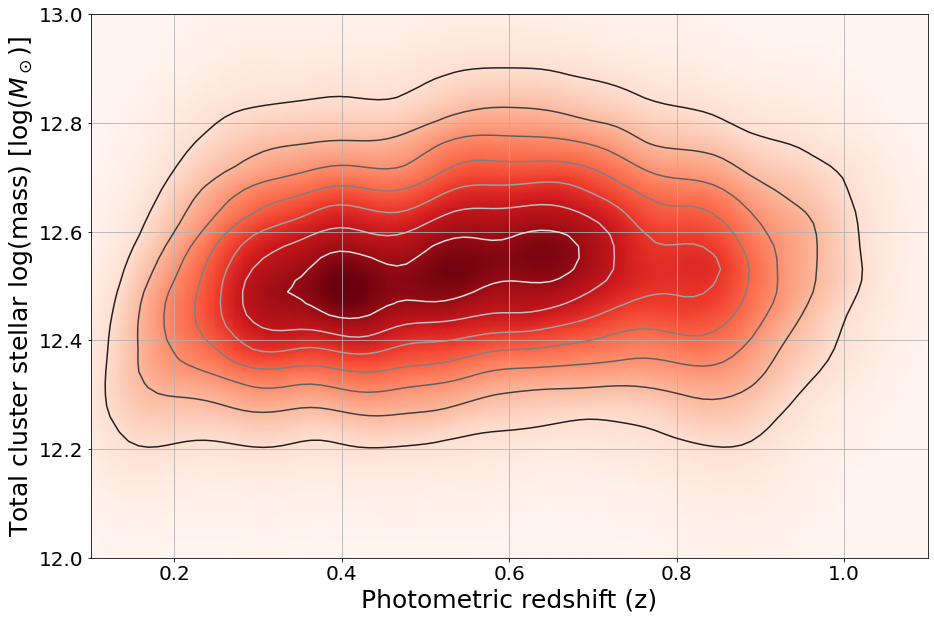

In [29]:
plt.figure(figsize = (15, 10))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 25)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 25)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.hexbin(clumpr[~clumpr.neighbor_mass.isna()].z_median_central, clumpr[~clumpr.neighbor_mass.isna()].neighbor_mass,cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray")
#plt.colorbar(label = "Number density of clusters")
plt.xlim(0.1, 1.1)
plt.ylim(12, 13)
plt.grid()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

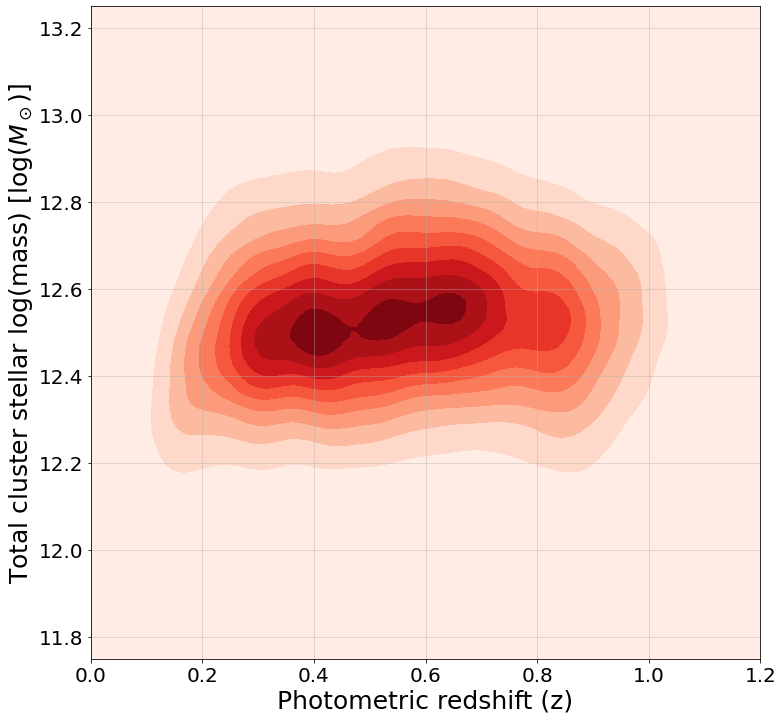

In [32]:
plt.figure(figsize = (12, 12))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 25)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
#plt.title("Cluster stellar log(mass) as a function of redshift       \n", fontsize = 30)
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
plt.contourf(xi-1.1, yi, zi.reshape(xi.shape), extent=[xbins.min()-1.1,xbins.max()-1.1,ybins.min(),ybins.max()],cmap = "Reds", levels = 10)
plt.contourf(xi, yi, zi.reshape(xi.shape), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],cmap = "Reds", levels = 10)
#plt.colorbar(label = "Number density of clusters")
plt.xlim(0, 1.2)
plt.ylim(11.75, 13.25)
plt.grid(alpha = 0.5)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("mass_red.pdf")
plt.show()

# North and South Mass distributions, before and after

In [42]:
north_results = Table.read("north_clusters_2023.fits").to_pandas()
south_results = Table.read("south_clusters_2023.fits").to_pandas()

# South

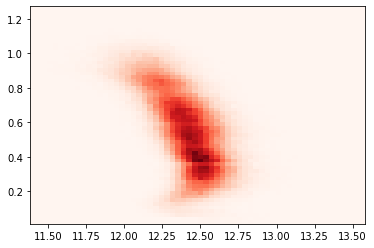

In [43]:
counts,ybins,xbins,image = plt.hist2d(np.log10(10**(south_results.neighbor_mass)/south_results.correction_factor), south_results.z_median_central,bins=60, cmap = "Reds")
data_kde = np.array([south_results.z_median_central, np.log10(10**(south_results.neighbor_mass)/south_results.correction_factor)])
k = kde.gaussian_kde(data_kde)
nbins = 100
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

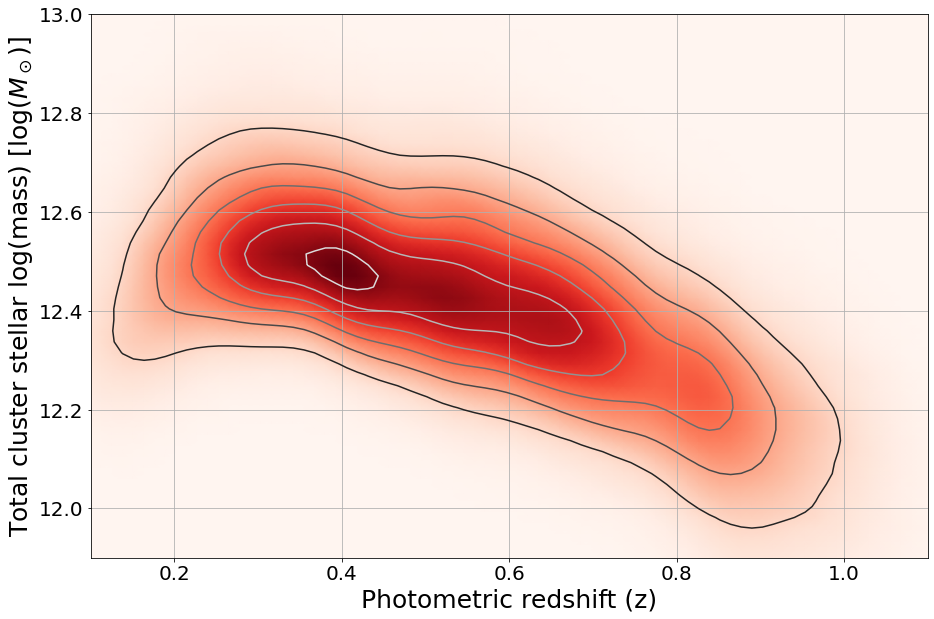

In [44]:
plt.figure(figsize = (15, 10))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 25)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 25)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray")
#plt.colorbar(label = "Number density of clusters")
plt.xlim(0.1, 1.1)
plt.ylim(11.9, 13)
plt.grid()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

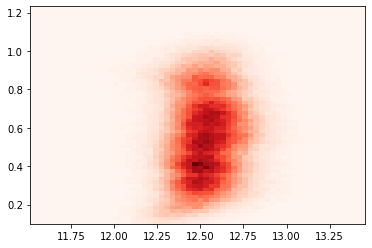

In [47]:
sclumpr = clumpr[clumpr.DEC_central<32].copy()
counts,ybins,xbins,image = plt.hist2d(sclumpr[~sclumpr.cluster_mass_onempc.isna()].cluster_mass_onempc, sclumpr[~sclumpr.cluster_mass_onempc.isna()].z_median_central,bins=60, cmap = "Reds")
data_kde = np.array([sclumpr[~sclumpr.cluster_mass_onempc.isna()].z_median_central, sclumpr[~sclumpr.cluster_mass_onempc.isna()].cluster_mass_onempc])
k = kde.gaussian_kde(data_kde)
nbins = 100
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

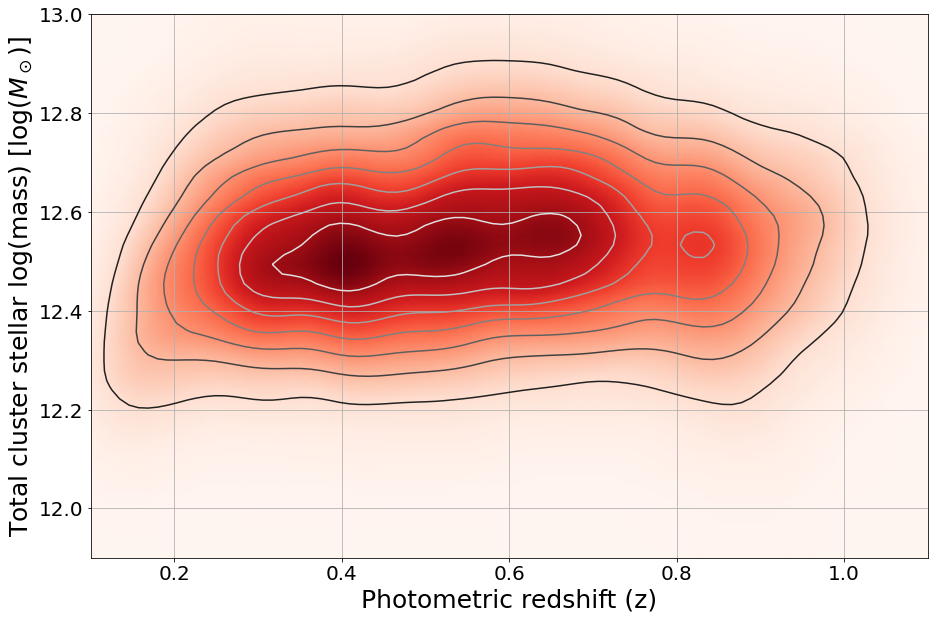

In [48]:
plt.figure(figsize = (15, 10))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 25)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 25)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray")
#plt.colorbar(label = "Number density of clusters")
plt.xlim(0.1, 1.1)
plt.ylim(11.9, 13)
plt.grid()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

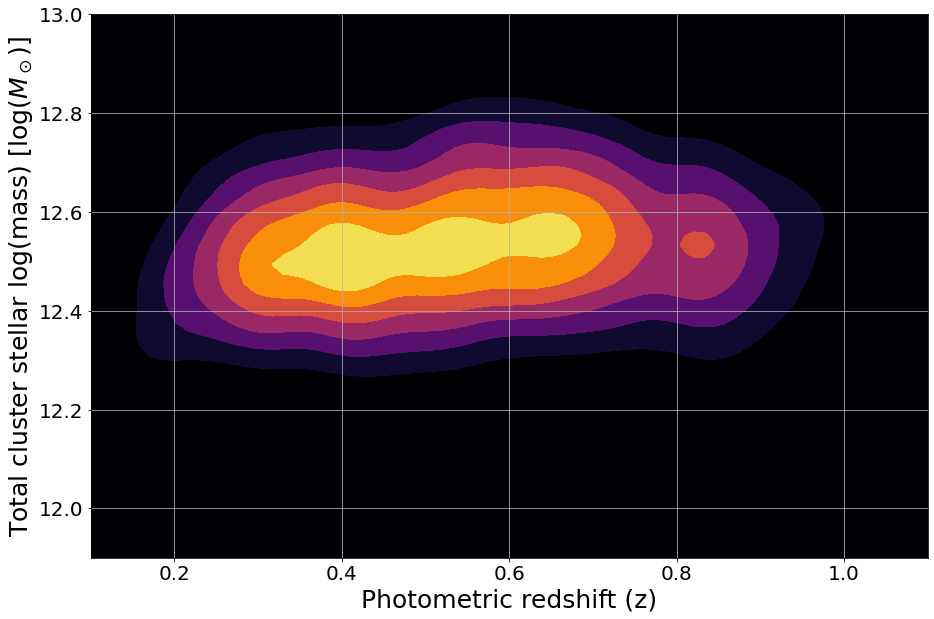

In [49]:
plt.figure(figsize = (15, 10))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 25)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 25)
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
plt.contourf(xi, yi, zi.reshape(xi.shape), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],cmap = "inferno", vmin = 1)
#plt.colorbar(label = "Number density of clusters")
plt.xlim(0.1, 1.1)
plt.ylim(11.9, 13)
plt.grid()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# North

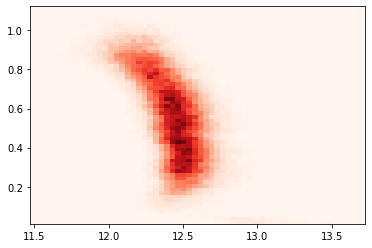

In [58]:
counts,ybins,xbins,image = plt.hist2d(np.log10(10**(north_results.neighbor_mass)/north_results.correction_factor), north_results.z_median_central,bins=60, cmap = "Reds")
data_kde = np.array([north_results.z_median_central, np.log10(10**(north_results.neighbor_mass)/north_results.correction_factor)])
k = kde.gaussian_kde(data_kde)
nbins = 100
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

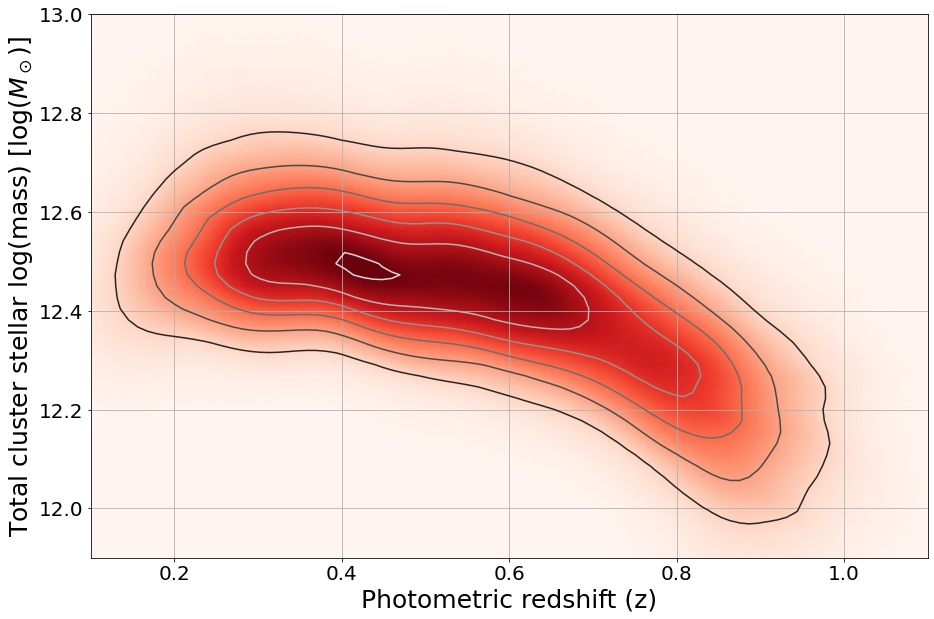

In [59]:
plt.figure(figsize = (15, 10))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 25)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 25)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray")
#plt.colorbar(label = "Number density of clusters")
plt.xlim(0.1, 1.1)
plt.ylim(11.9, 13)
plt.grid()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

<ipython-input-60-0534348b6e6c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sclumpr = clumper.iloc[:89799].copy()[np.logical_and(clumper.z_median_central > 0.1, clumper.flag_duplicate == 0)].copy()


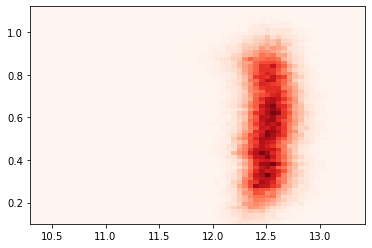

In [60]:
sclumpr = clumper.iloc[:89799].copy()[np.logical_and(clumper.z_median_central > 0.1, clumper.flag_duplicate == 0)].copy()
counts,ybins,xbins,image = plt.hist2d(sclumpr[~sclumpr.neighbor_mass.isna()].neighbor_mass, sclumpr[~sclumpr.neighbor_mass.isna()].z_median_central,bins=60, cmap = "Reds")
data_kde = np.array([sclumpr[~sclumpr.neighbor_mass.isna()].z_median_central, sclumpr[~sclumpr.neighbor_mass.isna()].neighbor_mass])
k = kde.gaussian_kde(data_kde)
nbins = 100
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

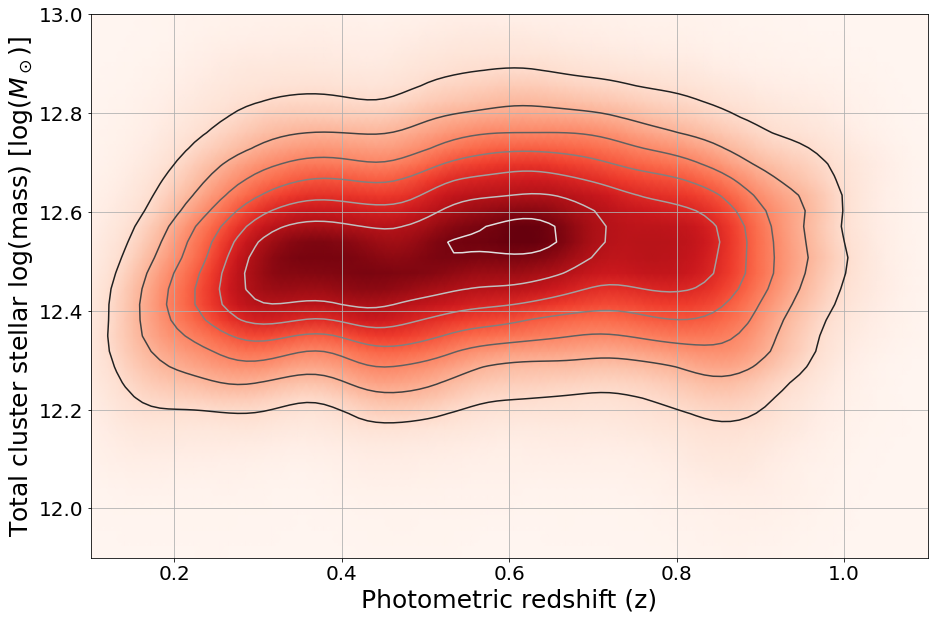

In [61]:
plt.figure(figsize = (15, 10))
plt.ylabel("Total cluster stellar log(mass) [log($M_\odot$)]", fontsize = 25)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 25)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray")
#plt.colorbar(label = "Number density of clusters")
plt.xlim(0.1, 1.1)
plt.ylim(11.9, 13)
plt.grid()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# Comparison with Zou

In [3]:
data = ascii.read("Data/clusters.dat").to_pandas()

In [4]:
columns = ["ID",
    "RA",
    "DEC",
    "zphot",
    "zspec",
    "den",
    "Bkg",
    "RAMdeg",
    "DEMdeg",
    "Ng",
    "Ltot",
    "M500",
    "R500",
    "Richness",
    "RABdeg",
    "DEBdeg",
    "zphotB",
    "e_zphotB",
    "zspecB",
    "gmag",
    "rmag",
    "zmag",
    "W1mag",
    "W2mag",
    "e_gmag",
    "e_rmag",
    "e_zmag",
    "e_W1mag",
    "e_W2mag",
    "gMag",
    "rMag",
    "zMag",
    "W1Mag",
    "W2Mag",
    "Mass",
    "b_Mass",
    "B_Mass"]
data.columns = columns

In [8]:
H, xedges, yedges = np.histogram2d(data.DEC, (data.RA-298)%360*np.cos(np.pi/180*data.DEC), bins = (np.linspace(-70, 90, 10000), np.linspace(-3, 325, 10000)))

In [9]:
#x_scale = (x_edges.max() - x_edges.min())/(H.shape[1] - 1)
#y_scale = (y_edges.max() - y_edges.min())/(H.shape[0] - 1)
#x_scale = xedges[1]-xedges[0]
#y_scale = yedges[1]-yedges[0]
#x_scale = (np.max(data.DEC_central) - np.min(data.DEC_central))/(H.shape[1] - 1)
#y_scale = (np.max((data.RA_central-300)%360*np.cos(np.pi/180*data.DEC_central)) - np.min((data.RA_central-300)%360*np.cos(np.pi/180*data.DEC_central)))/(H.shape[1] - 1)
x_scale = (90 + 70)/(H.shape[1] - 1)
y_scale = (325+3)/(H.shape[1] - 1)

In [10]:
dim_x = 0.285/x_scale
dim_y = 0.285/y_scale

In [11]:
test = np.zeros((int(np.round(dim_x*2)+1), int(np.round(dim_y*2)+1)), dtype = "int")
x,y = np.ogrid[0:int(np.round(dim_x*2)+1), 0:int(np.round(dim_y*2)+1)]

#get the x and y center points of our image
center_x = test.shape[0]/2 - 1
center_y = test.shape[1]/2 - 1

#create a circle mask which is centered in the middle of the image, and with radius 10 pixels
circle_mask = (x-center_x)**2/(dim_x**2) + (y-center_y)**2/(dim_y**2) <= 1

test[circle_mask] = 1
kernel = test.copy()

In [12]:
#ra_min = ((data.RA_central-300)%360*np.cos(np.pi/180*data.DEC_central)).min()
ra_min = -3
data["ra_indices"] = np.round(((data.RA-298)%360*np.cos(np.pi/180*data.DEC) - ra_min)/y_scale)
#data["dec_indices"] = np.round((data.DEC_central - data.DEC_central.min())/x_scale)
data["dec_indices"] = np.round((data.DEC - -70)/x_scale)

In [13]:
sampled = data.sample(1000, random_state = 1)
ra_list = sampled.RA*np.cos(np.pi/180*sampled.DEC)
dec_list = sampled.DEC

In [14]:
dec_indices = (dec_list - xedges.min())/x_scale
ra_indices = (ra_list - yedges.min())/y_scale

In [15]:
H0 = np.clip(H, 0, 1)

In [16]:
test2 = np.zeros((101, 101), dtype = "int")
x,y = np.ogrid[0:101, 0:101]

#get the x and y center points of our image
center_x = test2.shape[0]//2
center_y = test2.shape[1]//2

#create a circle mask which is centered in the middle of the image, and with radius 10 pixels
circle_mask = (x-center_x)**2 + (y-center_y)**2 <= 50**2

test2[circle_mask] = 1
test2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
kernel = test2.astype("uint8")
closing = cv.morphologyEx(H0, cv.MORPH_CLOSE, kernel)

In [18]:
kernel2 = test.astype("uint8")
eroded = cv.erode(closing, kernel2)

In [19]:
data["edge_mask"] = eroded[data.dec_indices.astype("int").to_list(), data.ra_indices.astype("int").to_list()]

In [25]:
np.save("zou_mask", eroded[data.dec_indices.astype("int").to_list(), data.ra_indices.astype("int").to_list()])

In [5]:
data["edge_mask"] = np.load("zou_mask.npy")

In [6]:
zou = data[data.edge_mask == 1]

In [28]:
data2 = data[data.edge_mask == 0]
len(data2)

9534

In [29]:
H_uneq2, xedges, yedges = np.histogram2d(data2.DEC, (data2.RA-298)%360, bins = (np.linspace(np.min(data2.DEC), np.max(data2.DEC), 1000), np.linspace(np.min((data2.RA-298)%360), np.max((data2.RA-298)%360), 1000)))

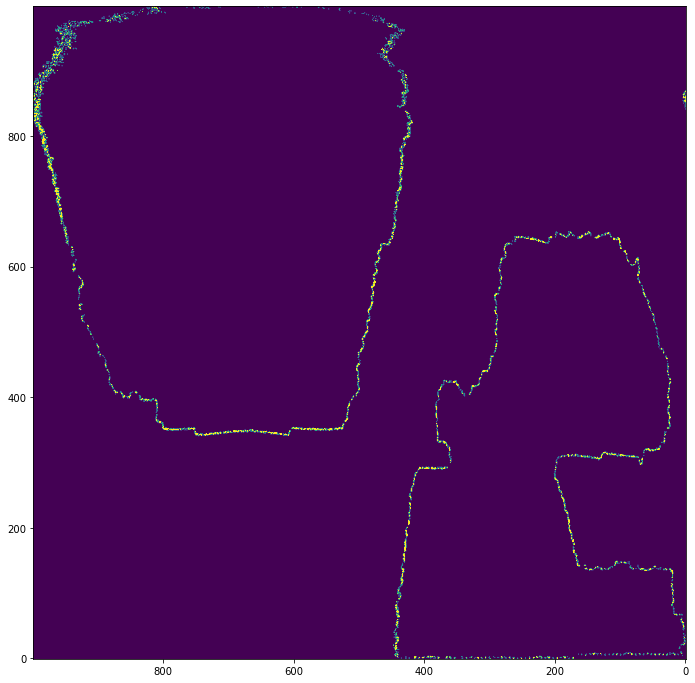

In [30]:
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq2, vmax = 1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [17]:
c = SkyCoord(ra=clumpr.RA_central.to_numpy()*u.degree, dec=clumpr.DEC_central.to_numpy()*u.degree)
catalog = SkyCoord(ra=zou.RA.to_numpy()*u.degree, dec=zou.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [18]:
len(c_matches)/len(clumpr)

0.8544781068534364

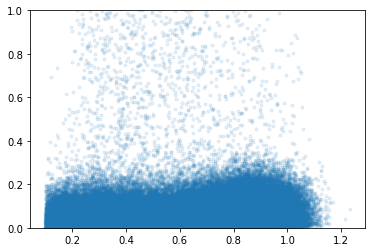

In [19]:
plt.plot(clumpr.z_median_central, (d2d).value, ".", alpha = 0.1)
plt.ylim(0, 1)
plt.show()

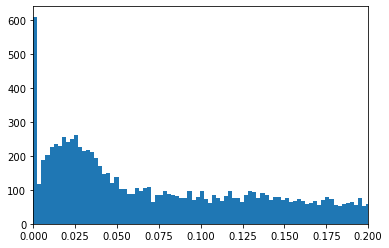

In [22]:
z_mask = np.logical_and(clumpr.z_median_central < 0.2, clumpr.z_median_central > 0.1)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

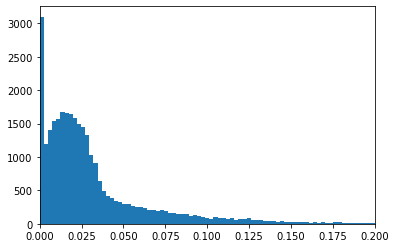

In [23]:
z_mask = np.logical_and(clumpr.z_median_central < 0.3, clumpr.z_median_central > 0.2)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

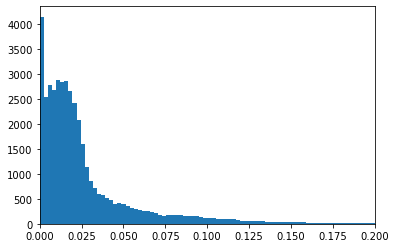

In [24]:
z_mask = np.logical_and(clumpr.z_median_central < 0.4, clumpr.z_median_central > 0.3)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

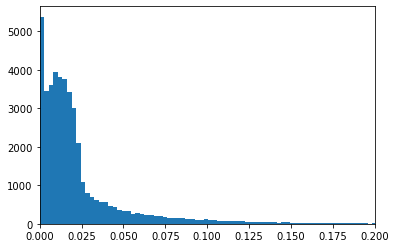

In [25]:
z_mask = np.logical_and(clumpr.z_median_central < 0.5, clumpr.z_median_central > 0.4)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

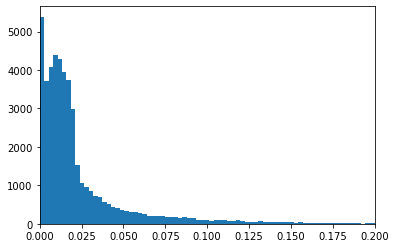

In [26]:
z_mask = np.logical_and(clumpr.z_median_central < 0.6, clumpr.z_median_central > 0.5)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

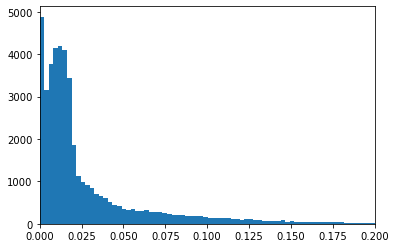

In [27]:
z_mask = np.logical_and(clumpr.z_median_central < 0.7, clumpr.z_median_central > 0.6)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

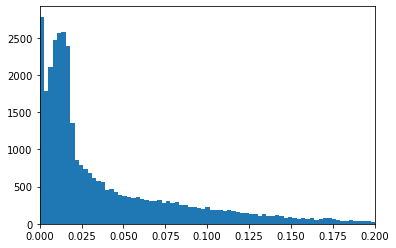

In [28]:
z_mask = np.logical_and(clumpr.z_median_central < 0.8, clumpr.z_median_central > 0.7)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

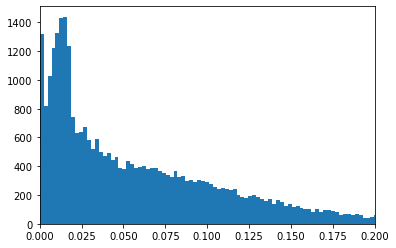

In [29]:
z_mask = np.logical_and(clumpr.z_median_central < 0.9, clumpr.z_median_central > 0.8)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

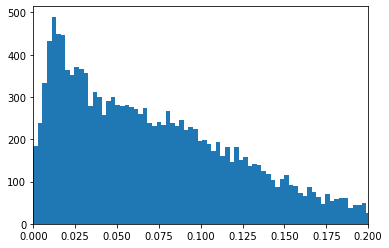

In [30]:
z_mask = np.logical_and(clumpr.z_median_central < 1, clumpr.z_median_central > 0.9)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

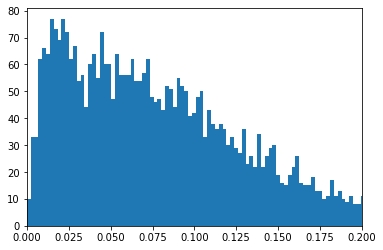

In [31]:
z_mask = np.logical_and(clumpr.z_median_central < 1.1, clumpr.z_median_central > 1)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

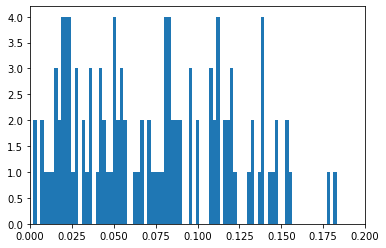

In [32]:
z_mask = np.logical_and(clumpr.z_median_central < 1.2, clumpr.z_median_central > 1.1)
plt.hist((d2d).value[z_mask], bins = 3000)
#plt.ylim(0, 1)
plt.xlim(0, 0.2)
plt.show()

In [34]:
clumpr.sort_values("neighbor_mass", ascending = False)[["RA_central", "DEC_central"]].head(60)

RA_central  DEC_central
258125  262.916375    22.866265
3289    109.398539    37.754779
36321   269.219300    40.135312
167918  343.147767     4.523542
237033  351.865118    -2.077098
124990   30.070957    27.805921
9112    132.744410    48.500644
210316   39.969665    -1.571922
26590   139.472562    51.727031
75759   213.696609    54.784308
82218   175.603264    58.534797
137390    3.586243   -30.400146
77436   137.712674    38.839539
73912   215.168253    39.919530
288955  333.407609    -8.424340
118207   44.421151   -22.154941
235474  344.657819   -13.886452
6626    207.902007    52.104681
138135  332.941336    -3.829000
272519  350.246408    29.216867
319537   48.753697   -27.302932
147234  221.089200     9.447583
40813   257.397317    47.531214
172596   76.186384   -27.992520
263652  164.249961    -3.626715
321070  177.398679    22.398470
9724    184.800888    50.909656
142266  324.503521   -60.131666
179341  347.092614    -2.192169
315692    9.225326   -12.109467
18857   231.638397    54.152032
208696   48.218195     1.878807
280460  263.100388    19.554622
200199  327.588904    -8.788423
106183  126.511816     4.324955
34785   121.146211    33.085673
301172   71.698793   -37.063019
312371    8.039177    18.115538
196698   22.968936   -13.611266
276154   12.295633   -24.678640
91149    24.354089    -8.456368
951     203.833722    41.001170
193971  197.872970    -1.341088
287376   47.198058    -9.714837
6625    203.160039    50.559924
242987  183.077004    27.548648
312372    4.639935    16.437758
212122   43.588368   -60.868847
10570   226.384527    33.213666
196697   24.293988   -10.572801
268070  125.015554    23.417334
278913  322.097574     1.593476
37523   198.771808    51.817402
87494   140.645048    62.608311
14216   270.277202    39.868552
252628   70.189892   -18.473646
77434   132.532983    36.070479
276155   10.854721   -20.616964
253501   11.517070    -3.985817
272518  350.561514    28.520936

In [9]:
from astropy.cosmology import LambdaCDM as Cos
from scipy.interpolate import interp1d
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
z_array = np.linspace(1e-2, 2, 500)
sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")

c = SkyCoord(ra=clumpr.RA_central.to_numpy()*u.degree, dec=clumpr.DEC_central.to_numpy()*u.degree)
catalog = SkyCoord(ra=zou.RA.to_numpy()*u.degree, dec=zou.DEC.to_numpy()*u.degree)

max_sep = 5 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [10]:
len(c_matches)/len(clumpr)

0.8544781068534364

In [15]:
clumpr[np.logical_and(~sep_constraint, clumpr.z_median_central > 0.75)][["RA_central", "DEC_central"]].head(60)

RA_central  DEC_central
80   191.979773    32.769054
131  199.183370    34.023371
147  199.274718    34.450722
165  192.203582    32.898107
213  197.271064    32.463214
217  190.975938    32.511413
247  192.243988    32.970725
263  198.518677    34.139308
271  192.546535    34.384321
274  192.157625    34.652827
277  199.060520    32.792607
289  192.110069    33.725724
299  195.801402    32.518380
300  192.725946    33.370083
301  194.347482    34.682466
303  198.158346    33.275943
306  194.132840    32.657384
316  198.767917    33.698222
329  199.621543    33.730654
332  195.278667    34.057899
334  193.537161    34.969224
341  195.789594    34.496150
349  195.299065    34.551527
350  191.336500    34.736981
352  199.421953    34.629512
358  190.663577    34.784808
360  195.837232    32.643381
365  198.960289    34.039113
370  196.496602    34.835408
379  197.088272    32.450586
387  196.818326    33.383185
404  191.093681    34.543163
413  199.157227    34.317516
417  192.698979    34.068811
423  197.169115    34.336966
431  191.242314    34.328961
435  195.437576    34.567046
437  197.397607    33.378880
489  180.550146    65.564894
552  182.001656    66.814702
555  186.488623    69.884222
564  183.485207    68.590904
566  182.926692    68.272266
574  184.858978    65.585741
580  181.989812    67.465180
582  188.154910    65.324826
604  185.738654    65.936184
610  180.064360    65.121165
611  189.070814    66.622542
647  186.038466    68.078262
651  182.897417    67.739691
655  181.547642    65.560481
666  181.758984    65.793653
668  182.415098    69.030712
670  186.924081    65.515555
678  185.800007    66.499822
681  188.909383    65.526270
685  186.774017    65.973076
696  180.658912    69.962933
707  186.964264    65.168242

In [89]:
clumpr[np.logical_and(d2d.value < 10/60, d2d.value > 0.3/60)][["RA_central", "DEC_central"]].head(10)

RA_central  DEC_central
0   291.871958    70.356011
1   291.519829    70.026803
2   292.187987    71.378077
4   292.277507    71.480220
5   290.185849    72.312409
6   290.213292    70.212077
7   192.255377    81.385309
8   192.246132    83.158134
9   194.794139    82.620191
10  198.953871    80.988101

In [88]:
zou.iloc[idx[np.logical_and(d2d.value < 10/60, d2d.value > 1/60)]][["RA", "DEC"]].head(10)

RA        DEC
14954  291.793595  70.380242
14953  291.508323  70.005924
13673  292.227227  71.404785
13674  292.293061  71.426858
647    194.738761  82.594881
1429   193.644698  80.693069
1017   199.501818  81.876498
1011   191.852435  81.884566
1944   192.302641  80.214021
1434   197.271364  81.127201

In [86]:
d2d.unit

Unit("deg")

(0.0, 1.0)

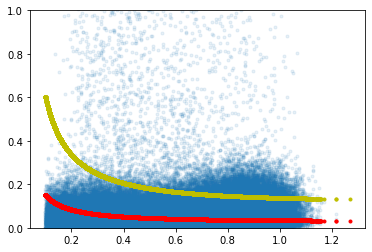

In [117]:
plt.plot(clumpr.z_median_central, (d2d).value, ".", alpha = 0.1)
plt.plot(clumpr.z_median_central, (180/np.pi)*radius_threshold(clumpr.z_median_central),".r")
plt.plot(clumpr.z_median_central, 4*(180/np.pi)*radius_threshold(clumpr.z_median_central),".y")
plt.ylim(0, 1)

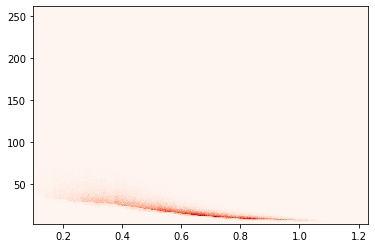

In [59]:
counts,xbins,ybins,image = plt.hist2d(clumpr[~clumpr.richness_onempc.isna()].z_median_central, clumpr[~clumpr.richness_onempc.isna()].richness_onempc,bins=500, cmap = "Reds")
counts2,xbins2,ybins2,image2 = plt.hist2d(clumpr[np.logical_and(~clumpr.richness_onempc.isna(), sep_constraint)].z_median_central, clumpr[np.logical_and(~clumpr.richness_onempc.isna(), sep_constraint)].richness_onempc,bins=[xbins, ybins], cmap = "Reds")

<ipython-input-61-10f480b731b7>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(counts2.T/counts.T, aspect = "auto", origin = "lower")


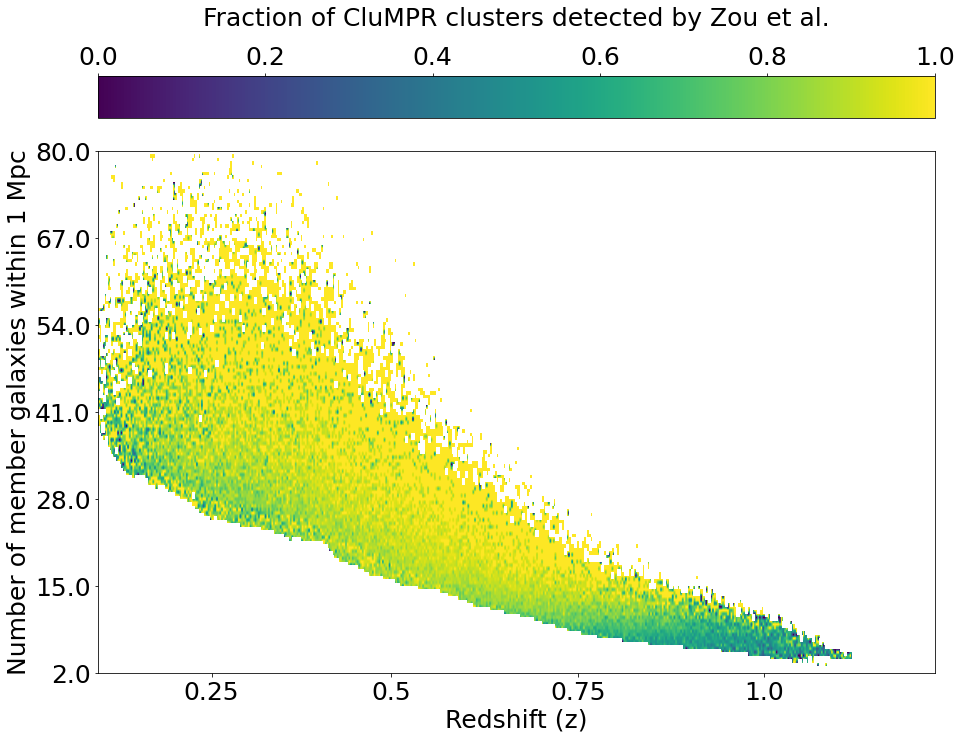

In [61]:
plt.figure(figsize = (15,12))
plt.imshow(counts2.T/counts.T, aspect = "auto", origin = "lower")
plt.yticks(ticks = np.arange(501)[::25], labels = np.round(ybins[::25]), fontsize = 25)
plt.xticks(ticks = [68, 175, 287, 398], labels = np.round([xbins[68], xbins[175], xbins[287], xbins[398]], 2), fontsize = 25)
plt.xlim(0, 500)
plt.ylim(0, 150)
cbar = plt.colorbar(location = "top")
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(25)
cbar.set_label(label="Fraction of CluMPR clusters detected by Zou et al.",fontsize = 25, labelpad = 20)
plt.xlabel("Redshift (z)", fontsize = 25)
plt.ylabel("Number of member galaxies within 1 Mpc", fontsize = 25)
plt.savefig("clumpr_zou.pdf")
plt.show()

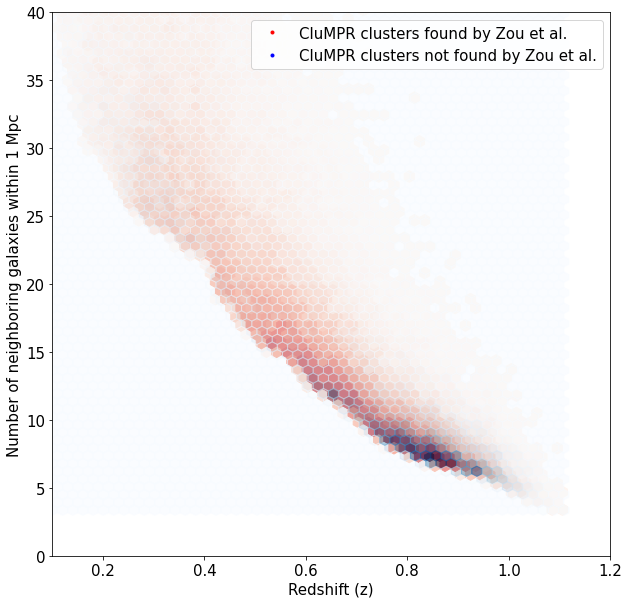

In [74]:
plt.figure(figsize = (10, 10))
plt.hexbin(clumpr[np.logical_and(sep_constraint, clumpr.DEC_central>32)].z_median_central, clumpr[np.logical_and(sep_constraint, clumpr.DEC_central>32)].richness_onempc, gridsize=(50,200), alpha = 1, cmap = "Reds",mincnt=1)
plt.hexbin(clumpr[np.logical_and(~sep_constraint, clumpr.DEC_central>32)].z_median_central, clumpr[np.logical_and(~sep_constraint, clumpr.DEC_central>32)].richness_onempc, gridsize=(50,100), alpha = 0.5, cmap = "Blues",mincnt=0)
plt.plot( np.NaN, np.NaN, ".r", label = "CluMPR clusters found by Zou et al.")
plt.plot( np.NaN, np.NaN, ".b", label = "CluMPR clusters not found by Zou et al.")
plt.xlabel("Redshift (z)", fontsize = 15)
plt.ylabel("Number of neighboring galaxies within 1 Mpc", fontsize = 15)
#plt.title("1 Mpc richness vs redshift for CluMPR clusters", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15, loc = "upper right")
plt.ylim(0, 40)
plt.xlim(0.1, 1.2)
plt.show()

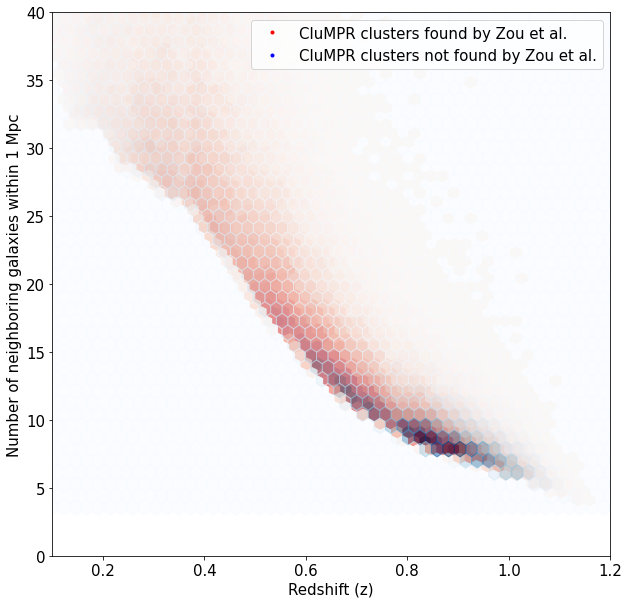

In [75]:
plt.figure(figsize = (10, 10))
plt.hexbin(clumpr[np.logical_and(sep_constraint, clumpr.DEC_central<32)].z_median_central, clumpr[np.logical_and(sep_constraint, clumpr.DEC_central<32)].richness_onempc, gridsize=(50,200), alpha = 1, cmap = "Reds", mincnt = 1)
plt.hexbin(clumpr[np.logical_and(~sep_constraint, clumpr.DEC_central<32)].z_median_central, clumpr[np.logical_and(~sep_constraint, clumpr.DEC_central<32)].richness_onempc, gridsize=(50,100), alpha = 0.5, cmap = "Blues", mincnt = 0)
plt.plot( np.NaN, np.NaN, ".r", label = "CluMPR clusters found by Zou et al.")
plt.plot( np.NaN, np.NaN, ".b", label = "CluMPR clusters not found by Zou et al.")
plt.xlabel("Redshift (z)", fontsize = 15)
plt.ylabel("Number of neighboring galaxies within 1 Mpc", fontsize = 15)
#plt.title("1 Mpc richness vs redshift for CluMPR clusters", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15, loc = "upper right")
plt.ylim(0, 40)
plt.xlim(0.1, 1.2)
plt.show()

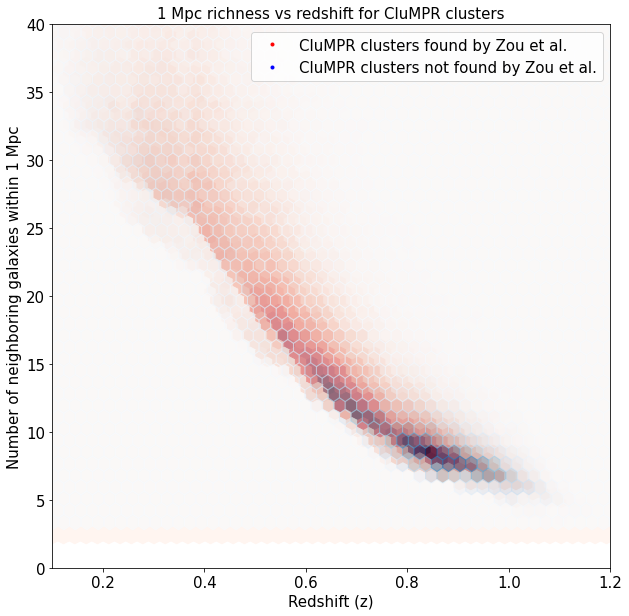

In [66]:
plt.figure(figsize = (10, 10))

#plt.hexbin(clumpr[sep_constraint].z_median_central, clumpr[sep_constraint].richness_onempc-100, gridsize=(100,200), alpha = 1, cmap = "Reds")
#plt.hexbin(clumpr[~sep_constraint].z_median_central, clumpr[~sep_constraint].richness_onempc-100, gridsize=(100,200), alpha = 0.5, cmap = "Blues")

plt.hexbin(clumpr[sep_constraint].z_median_central, clumpr[sep_constraint].richness_onempc, gridsize=(50,200), alpha = 1, cmap = "Reds")
plt.hexbin(clumpr[~sep_constraint].z_median_central, clumpr[~sep_constraint].richness_onempc, gridsize=(50,100), alpha = 0.5, cmap = "Blues")

plt.plot( np.NaN, np.NaN, ".r", label = "CluMPR clusters found by Zou et al.")
plt.plot( np.NaN, np.NaN, ".b", label = "CluMPR clusters not found by Zou et al.")
plt.xlabel("Redshift (z)", fontsize = 15)
plt.ylabel("Number of neighboring galaxies within 1 Mpc", fontsize = 15)
plt.title("1 Mpc richness vs redshift for CluMPR clusters", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15, loc = "upper right")
plt.ylim(0, 40)
plt.xlim(0.1, 1.2)
plt.show()

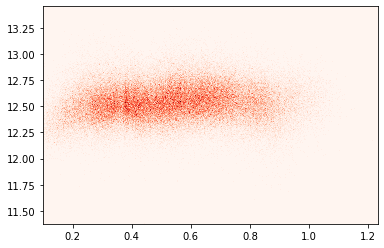

In [114]:
counts,xbins,ybins,image = plt.hist2d(clumpr[~clumpr.cluster_mass_onempc.isna()].z_median_central, clumpr[~clumpr.cluster_mass_onempc.isna()].cluster_mass_onempc,bins=500, cmap = "Reds")
counts2,xbins2,ybins2,image2 = plt.hist2d(clumpr[np.logical_and(~clumpr.cluster_mass_onempc.isna(), sep_constraint)].z_median_central, clumpr[np.logical_and(~clumpr.cluster_mass_onempc.isna(), sep_constraint)].cluster_mass_onempc,bins=[xbins, ybins], cmap = "Reds")

<ipython-input-115-a6dcc7e8a4f6>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(counts2.T/counts.T, aspect = "auto", origin = "lower")


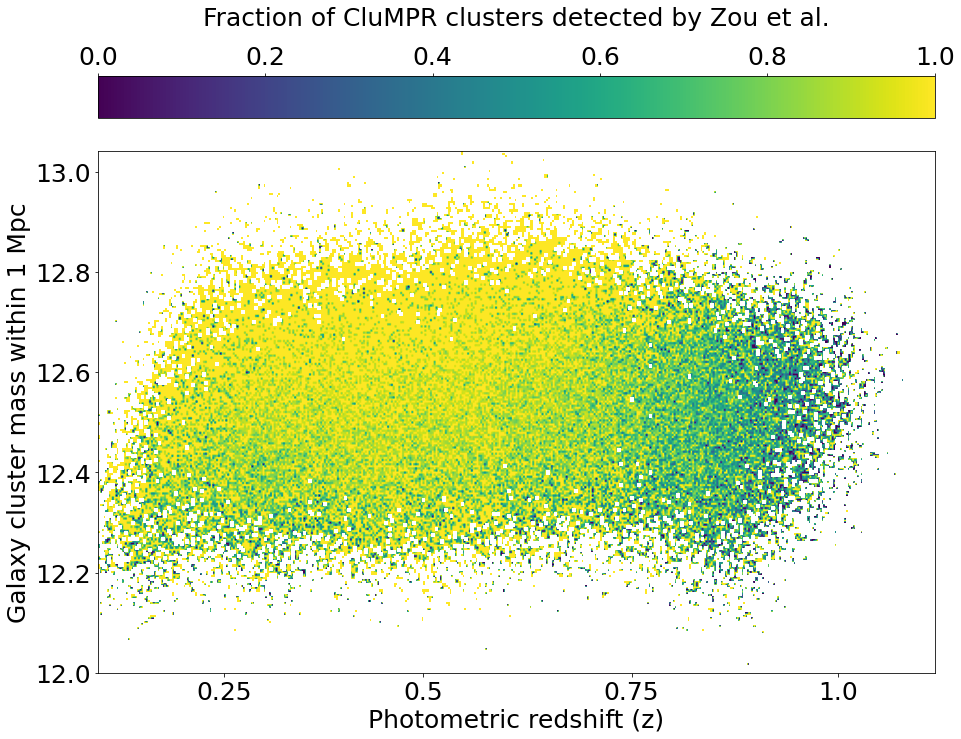

In [115]:
plt.figure(figsize = (15,12))
plt.imshow(counts2.T/counts.T, aspect = "auto", origin = "lower")
plt.yticks(ticks = np.arange(501)[150::48], labels = np.round(ybins[150::48], 2), fontsize = 25)
plt.xticks(ticks = [68, 175, 287, 398], labels = np.round([xbins[68], xbins[175], xbins[287], xbins[398]], 2), fontsize = 25)
plt.xlim(0, 450)
plt.ylim(150, 400)
cbar = plt.colorbar(location = "top")
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(25)
cbar.set_label(label="Fraction of CluMPR clusters detected by Zou et al.",fontsize = 25, labelpad = 20)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
plt.ylabel("Galaxy cluster mass within 1 Mpc", fontsize = 25)
#plt.grid()
plt.savefig("clumpr_zou_mass.pdf")
plt.show()

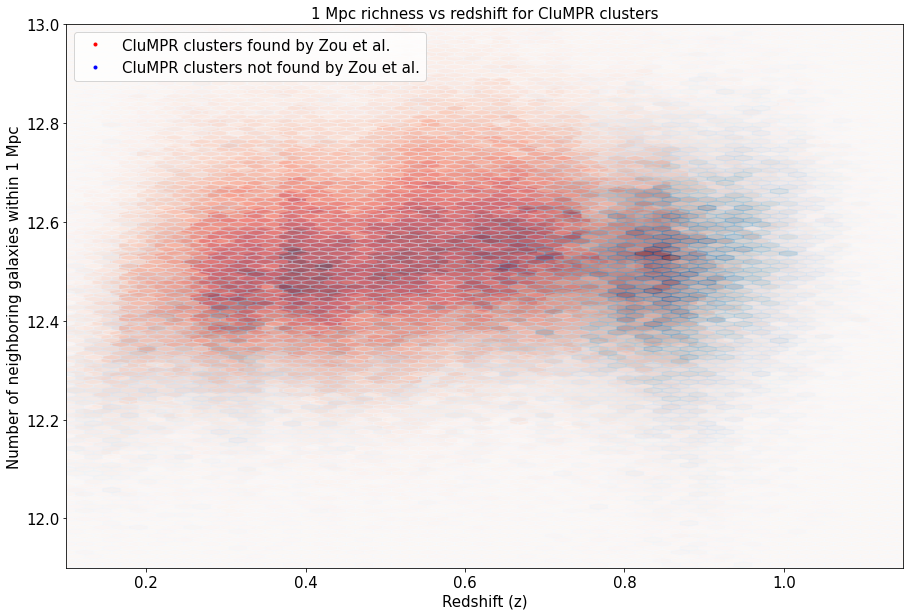

In [37]:
plt.figure(figsize = (15, 10))
plt.hexbin(clumpr[sep_constraint].z_median_central, clumpr[sep_constraint].cluster_mass_onempc, gridsize=(50,100), alpha = 1, cmap = "Reds")
plt.hexbin(clumpr[~sep_constraint].z_median_central, clumpr[~sep_constraint].cluster_mass_onempc, gridsize=(50,100), alpha = 0.4, cmap = "Blues")
plt.plot( np.NaN, np.NaN, ".r", label = "CluMPR clusters found by Zou et al.")
plt.plot( np.NaN, np.NaN, ".b", label = "CluMPR clusters not found by Zou et al.")
plt.xlabel("Redshift (z)", fontsize = 15)
plt.ylabel("Number of neighboring galaxies within 1 Mpc", fontsize = 15)
plt.title("1 Mpc richness vs redshift for CluMPR clusters", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.ylim(11.9, 13)
plt.xlim(0.1, 1.15)
plt.show()

In [163]:
clumpr[~sep_constraint].sort_values("neighbor_mass", ascending = False)[["RA_central", "DEC_central"]].head(60)

RA_central  DEC_central
142266  324.503521   -60.131666
212122   43.588368   -60.868847
91114   346.723184   -65.088206
290855   48.151670   -56.362321
112334  337.171836   -58.474214
193642   22.429611   -64.545137
284934  344.754097   -60.959554
107920   16.619767   -59.720156
130457   67.210630   -66.041049
290853   40.862878   -59.517264
142267  328.977815   -60.789912
129999  320.151236    17.912814
193643   24.455501   -63.161912
92159    62.165838   -18.978017
210022   99.688168   -53.972902
135017    8.471074   -63.444909
11587   106.169485    74.453832
209304  155.740591   -23.623687
266714   66.085658   -62.704880
180673   11.479005   -62.603942
248970   83.793411   -59.940780
142295  325.362626   -60.850081
161108  311.765733   -58.459282
139514  160.563996   -28.793053
135018    7.742995   -61.573544
298353  193.380196     1.232396
169258  154.554504   -29.823684
209305  153.987381   -24.145798
289630  221.540601   -12.557739
209303  155.473890   -24.788862
289626  222.477330   -14.381123
98999    56.357255   -66.494530
269420   23.793449   -42.673265
209306  155.321854   -23.307608
159374  329.211964   -59.869329
209307  154.248055   -22.088538
93602    52.510020   -62.532146
142292  320.658698   -62.281362
159335  326.368717   -59.556989
266695   66.433400   -61.713798
142272  327.178457   -61.279532
142280  326.903605   -64.651146
142268  329.994496   -62.753850
241902   82.354646   -60.854567
284935  341.414100   -62.035031
93598    53.684944   -60.154349
140795  337.811231   -64.375179
179051  314.101216   -64.000235
135023    7.023031   -63.366873
8249    124.292366    68.851390
180674   14.584240   -61.766839
266692   65.932076   -61.729444
266660  336.251091   -65.431777
245160  355.859189   -60.652617
215206   39.220619   -64.177951
159320  328.046086   -59.980289
93634    51.143534   -63.505606
212126   42.796324   -61.938231
99003    57.480363   -65.587016
116775  250.745567     3.267875

In [157]:
clumpr[~sep_constraint].sort_values("neighbor_mass", ascending = False)[["RA_central", "DEC_central"]].tail(60)

RA_central  DEC_central
245478  359.614181   -60.506548
55902   260.738525    39.482526
211420   33.716601    -0.624323
121698  222.270579    15.626298
174828  151.399174   -19.241012
32499   242.273044    54.290439
139390   75.483172   -63.231719
198772  346.491824    -6.923360
286958   58.977007   -38.616583
193640   56.541628   -55.370336
139370   78.403257   -63.547258
142190  193.167714    12.450055
285322  345.705519   -61.058639
139374   79.617359   -63.397336
242051   83.216977   -61.599063
198108   63.055098   -59.872458
19483   232.586766    50.665329
285325  345.575568   -61.352176
179048   37.827118   -59.683027
164509  206.507338     5.610193
215522   38.319525   -60.121571
135378    3.025508   -62.683773
49770   146.019031    45.695478
193969   26.016677   -61.951521
177016  175.829172    27.848587
283631  192.744265    24.219389
135385    4.932595   -64.028588
128868   24.119838   -57.600967
169252   14.457249   -49.836202
139663  162.351997   -27.019571
129976   73.421158    -4.193301
15924   193.273970    43.132913
291402   42.379096   -59.436963
52559   268.251753    48.795709
66986   258.118496    44.312958
154709   56.415876   -27.582568
291409   41.636719   -56.612562
197592   28.291205   -11.294469
139393   73.975565   -60.846295
94025    53.705008   -62.047992
180629  359.955588   -48.211904
179332  317.494126   -62.439822
284299   71.541536   -48.886512
207119  167.079378    20.306295
194764  196.012473    -1.887011
212560   48.549020   -62.738110
163625   32.103482   -42.031168
103483   13.578168   -29.715253
139406   71.483326   -64.422279
184140    8.498320    -5.573099
63867   163.191421    39.573365
141145  336.806605   -61.897220
94009    51.579877   -64.134280
212566   44.767996   -61.802425
128869   23.752852   -57.385066
244059  185.684054    29.919336
40052   238.748551    56.068323
127037    3.976924   -39.395494
183462   71.607183   -50.155734
238478   48.002194   -65.792083

In [97]:
catalog = SkyCoord(ra=clumpr.RA_central.to_numpy()*u.degree, dec=clumpr.DEC_central.to_numpy()*u.degree)
c = SkyCoord(ra=zou.RA.to_numpy()*u.degree, dec=zou.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [98]:
len(c_matches)/len(zou)

0.5885669186924796

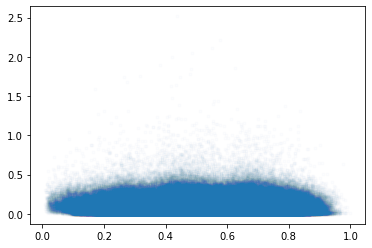

In [67]:
plt.plot(zou.zphot, d2d, ".", alpha = 0.01)

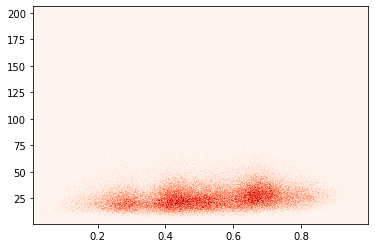

In [101]:
counts,xbins,ybins,image = plt.hist2d(zou[~zou.Richness.isna()].zphot, zou[~zou.Richness.isna()].Richness,bins=500, cmap = "Reds")
counts2,xbins2,ybins2,image2 = plt.hist2d(zou[np.logical_and(~zou.Richness.isna(), sep_constraint)].zphot, zou[np.logical_and(~zou.Richness.isna(), sep_constraint)].Richness,bins=[xbins, ybins], cmap = "Reds")

In [102]:
xbins[400]

0.8004538

<ipython-input-111-e4496b0d4e3b>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(counts2.T/counts.T, aspect = "auto", origin = "lower")


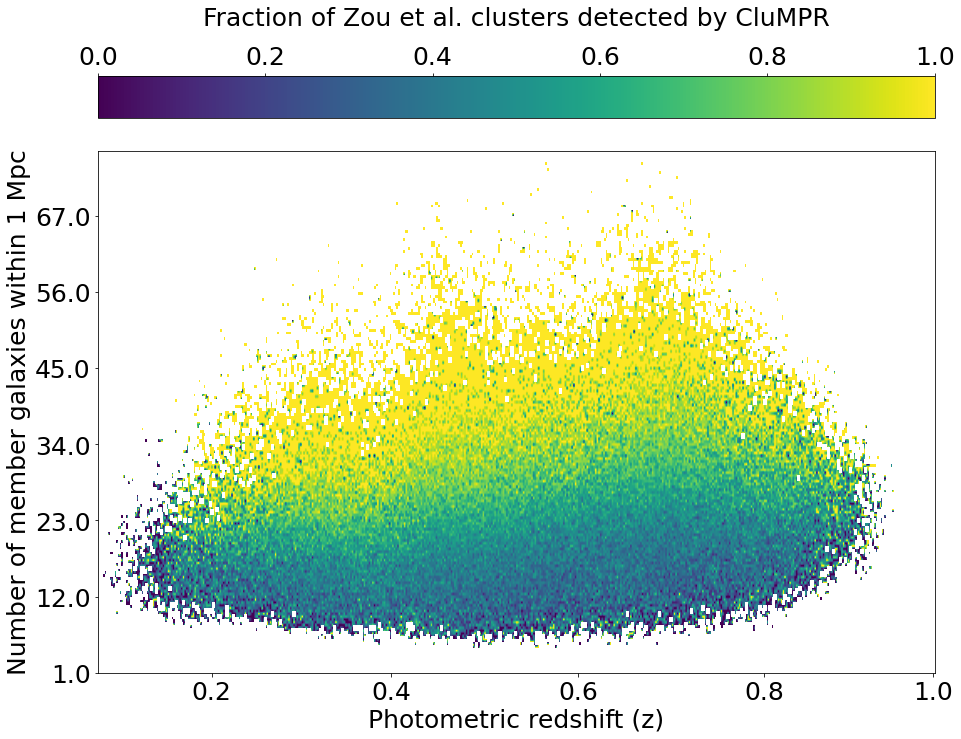

In [111]:
plt.figure(figsize = (15,12))
plt.imshow(counts2.T/counts.T, aspect = "auto", origin = "lower")
plt.yticks(ticks = np.arange(501)[::27], labels = np.round(ybins[::27]), fontsize = 25)
plt.xticks(ticks = [68, 175, 287, 398, 499], labels = np.round([xbins[96], xbins[196], xbins[300], xbins[400], xbins[499]], 2), fontsize = 25)
plt.xlim(0, 500)
plt.ylim(0, 185)
cbar = plt.colorbar(location = "top")
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(25)
cbar.set_label(label="Fraction of Zou et al. clusters detected by CluMPR",fontsize = 25, labelpad = 20)
plt.xlabel("Photometric redshift (z)", fontsize = 25)
plt.ylabel("Number of member galaxies within 1 Mpc", fontsize = 25)
plt.savefig("zou_clumpr.pdf")
plt.show()

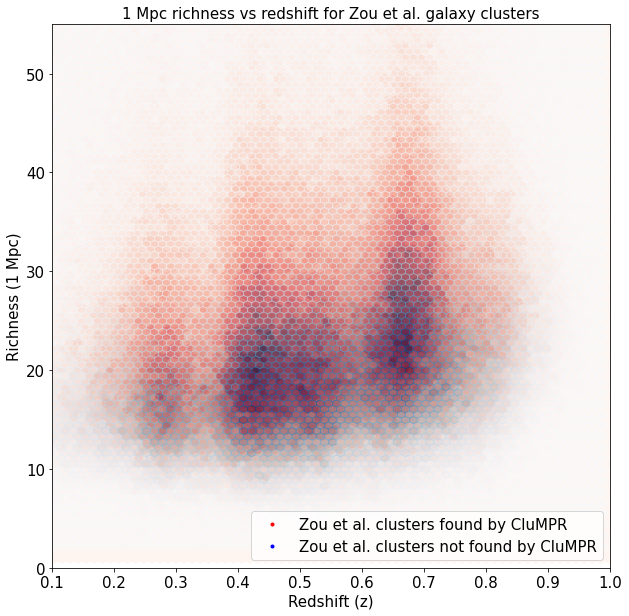

In [100]:
plt.figure(figsize = (10, 10))
plt.hexbin(zou[sep_constraint].zphot, zou[sep_constraint].Richness, gridsize=(75,150), cmap = "Reds", alpha = 1)
plt.hexbin(zou[~sep_constraint].zphot, zou[~sep_constraint].Richness, gridsize=(75,150), cmap = "Blues", alpha = 0.4)
plt.plot( np.NaN, np.NaN, ".r", label = "Zou et al. clusters found by CluMPR")
plt.plot( np.NaN, np.NaN, ".b", label = "Zou et al. clusters not found by CluMPR")
plt.xlabel("Redshift (z)", fontsize = 15)
plt.ylabel("Richness (1 Mpc)", fontsize = 15)
plt.title("1 Mpc richness vs redshift for Zou et al. galaxy clusters", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15, loc = "lower right")
plt.ylim(0, 55)
plt.xlim(0.1, 1)
plt.show()

In [142]:
len(zou[~sep_constraint])/len(zou)

0.17375914083547978

In [167]:
len(zou[sep_constraint])/len(zou)

0.8262408591645203

In [168]:
len(zou[np.logical_and(sep_constraint, zou.Richness > 30)])/len(zou[zou.Richness > 30])

0.9474445590113729

In [145]:
zou[~sep_constraint].sort_values("Richness", ascending = False)[["RA", "DEC"]].head(60)

RA        DEC
370118  189.716323  -4.630585
408264  358.557003 -10.419054
370282  198.095256  -4.336540
77750   126.360809  47.125170
534794  303.113884 -56.826785
75968   193.717412  47.017093
4913    101.417016  76.814501
42710   268.493625  58.085188
325846  131.732786   1.662031
122550  257.435160  34.433838
91094   271.889711  43.636961
483624   88.491113 -40.013760
47729   110.154076  55.650189
138694  145.457790  31.383506
391242  335.548217  -7.540554
467389   15.337591 -33.689690
249577  137.046207  13.109138
213175  117.003232  18.622144
51727   251.203965  54.893141
524673  312.777570 -52.712501
101727  207.411443  39.517819
313684  142.667964   3.782135
357553  177.299654  -2.331678
173997  137.260676  25.322157
526591   96.584081 -53.692880
75976   193.909758  47.189696
54103   250.878618  54.768434
32636    97.340910  61.661287
534910  310.768089 -56.237961
51722   250.480165  55.081397
176243  268.774402  25.095089
470257   66.293720 -34.100744
80167   102.918442  45.949507
83397   138.893104  44.633255
12430   101.215112  71.241101
253944  151.895822  12.049037
21780   246.491052  67.001883
357326  165.389472  -2.397571
525848   41.453286 -54.130568
299223  248.208709   5.597404
479325   70.015465 -38.312522
45807   140.703179  56.488429
131507  183.879509  32.657761
46663   217.140840  56.824095
78954   200.596428  46.768888
130058  104.829784  32.187946
515457   76.002179 -49.488867
279768  330.159262   8.773381
133317  345.177699  32.479182
53696   220.564956  54.684895
151809  231.889573  28.852376
283526  310.447906   8.251639
432494   39.157384 -19.365090
75969   193.541915  47.091552
371169  334.653673  -3.761231
196711   10.446337  21.391085
18125   161.425913  68.139028
42543   252.384894  58.033101
303033  237.225504   5.444459
276053  346.878268   9.329520

In [146]:
zou[~sep_constraint].sort_values("Richness", ascending = False)[["RA", "DEC"]].tail(60)

RA        DEC
292841   26.087287   6.614917
80783   142.262549  45.564835
380700   69.480057  -5.633657
204835   30.772390  19.899464
386136  195.913606  -6.630768
485640   93.560141 -40.859370
479891    2.252785 -39.075707
539300    1.383880 -58.793329
75489   161.994776  46.972536
370542  213.748923  -4.747310
29920   202.312194  62.615607
6094    185.509147  76.158838
133173  338.678069  32.627703
337220  338.703931   0.847635
234850  216.191319  15.509198
147751  220.689719  30.086918
538484   85.385044 -58.371611
1846    163.100334  80.138353
267938  328.386678  10.341096
245496  132.539726  13.972587
399931   20.472421  -9.018025
82356   256.800540  45.567781
383998   25.552050  -6.212974
499777   13.214176 -44.332540
338847   71.476603  -0.012469
102118  231.640485  39.883957
322335  173.325225   2.547522
387688  358.912047  -6.565468
458515    6.630793 -30.299804
354734  328.091215  -1.902579
160357  330.501233  27.766188
440779   63.450126 -22.924015
369532  154.749992  -4.009965
172090  265.975882  25.821117
510467   54.248337 -48.619481
170341  160.789874  25.990129
535003  320.383502 -56.508899
177737  122.760531  24.700143
112504  149.628635  37.725489
259936  321.025732  12.132291
184700   10.819961  23.426837
302206  185.768342   5.590060
217794  162.206231  18.451930
67417   136.226947  50.121927
95938   214.029507  41.890514
381423  160.524397  -6.087106
31864   219.975472  61.955210
309473  131.955114   4.577309
125846  352.163824  34.141800
59333    96.283538  52.000883
274446  194.597423  10.018691
458604   10.325399 -30.174557
535040  325.259855 -56.576588
405403  332.503443  -9.079431
424371   29.002037 -15.758533
215963  340.135274  19.080379
45079   278.728810  57.750902
58281   207.889209  52.792093
134072   31.985929  31.802043
171167  208.775711  25.925360

# Redmapper

In [172]:
redmapper_T = Table.read("Data/redmapper_dr8_public_v6.3_catalog.fits.gz")

In [187]:
redmapper = redmapper_T["ID","NAME","RA","DEC","Z_LAMBDA","Z_LAMBDA_ERR","LAMBDA","LAMBDA_ERR","S","Z_SPEC","OBJID","IMAG","IMAG_ERR"].to_pandas()

In [188]:
redmapper

ID                     NAME          RA        DEC  Z_LAMBDA  \
0           1  b'RMJ155820.0+271400.3'  239.583329  27.233413  0.094831   
1           2  b'RMJ164019.8+464241.5'  250.082548  46.711531  0.232764   
2           3  b'RMJ131129.5-012028.0'  197.872957  -1.341116  0.182398   
3           5  b'RMJ090912.2+105824.9'  137.300745  10.973595  0.170462   
4           6  b'RMJ133520.1+410004.1'  203.833723  41.001146  0.231747   
...       ...                      ...         ...        ...       ...   
26106  116793  b'RMJ011931.1+105519.9'   19.879442  10.922196  0.484857   
26107  120188  b'RMJ010741.2+282925.5'   16.921837  28.490415  0.404646   
26108  146982  b'RMJ120319.4+522213.6'  180.830799  52.370432  0.395463   
26109  163744  b'RMJ101517.8+433807.3'  153.824226  43.635358  0.480913   
26110  215682  b'RMJ090351.2+151206.2'  135.963371  15.201732  0.486754   

       Z_LAMBDA_ERR      LAMBDA  LAMBDA_ERR         S    Z_SPEC  \
0          0.004582  169.837845    4.187026  1.011366  0.090807   
1          0.006156  199.539276    5.299827  0.995171 -1.000000   
2          0.003937  164.712173    4.241623  1.006547 -1.000000   
3          0.003608  174.704178    4.947864  1.014544 -1.000000   
4          0.006067  189.181152    5.613359  1.010038  0.228309   
...             ...         ...         ...       ...       ...   
26106      0.015815   41.970650    9.002756  1.953025  0.568342   
26107      0.016744   27.875051    4.537112  1.360950 -1.000000   
26108      0.019532   24.579977    3.116970  1.149957 -1.000000   
26109      0.013660   33.305824    6.515804  1.594683 -1.000000   
26110      0.015275   34.236374    6.740537  1.703797 -1.000000   

                     OBJID  IMAG  IMAG_ERR  
0      1237662340012638224   0.0       0.0  
1      1237651715872325879   0.0       0.0  
2      1237655500272500810   0.0       0.0  
3      1237671260126576920   0.0       0.0  
4      1237662306722447498   0.0       0.0  
...                    ...   ...       ...  
26106  1237678918065718011   0.0       0.0  
26107  1237680283847098627   0.0       0.0  
26108  1237657856610140428   0.0       0.0  
26109  1237661358071612003   0.0       0.0  
26110  1237667782814269490   0.0       0.0  

[26111 rows x 13 columns]

In [189]:
catalog = SkyCoord(ra=clumpr.RA_central.to_numpy()*u.degree, dec=clumpr.DEC_central.to_numpy()*u.degree)
c = SkyCoord(ra=redmapper.RA.to_numpy()*u.degree, dec=redmapper.DEC.to_numpy()*u.degree)

max_sep = 10.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [192]:
len(redmapper[sep_constraint])

25364

In [193]:
len(redmapper[sep_constraint])/len(redmapper)

0.971391367622841

In [216]:
max_sep.value

10.0

In [214]:
np.max((d2d).value)

3.0206107651699754

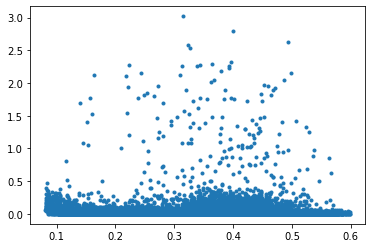

In [211]:
plt.plot(redmapper.Z_LAMBDA, (d2d*u.arcmin).value, ".")


In [5]:
from astropy.cosmology import LambdaCDM as Cos
from scipy.interpolate import interp1d
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
z_array = np.linspace(1e-2, 5, 500)
ang_diam_d = (cos.comoving_distance(z_array))/(1+z_array)
phys_ang = interp1d(z_array, ang_diam_d, kind = "linear", fill_value = "extrapolate")

In [6]:
from importlib.metadata import version
version('astropy')

'4.2.1'

In [69]:
radius_threshold(0.3)

array(921.57866526)

In [70]:
5*radius_threshold(1)*(180/np.pi)/(10/60)

2863410.135875217

Text(0, 0.5, 'Equivalent of 10 arcminutes in Mpc')

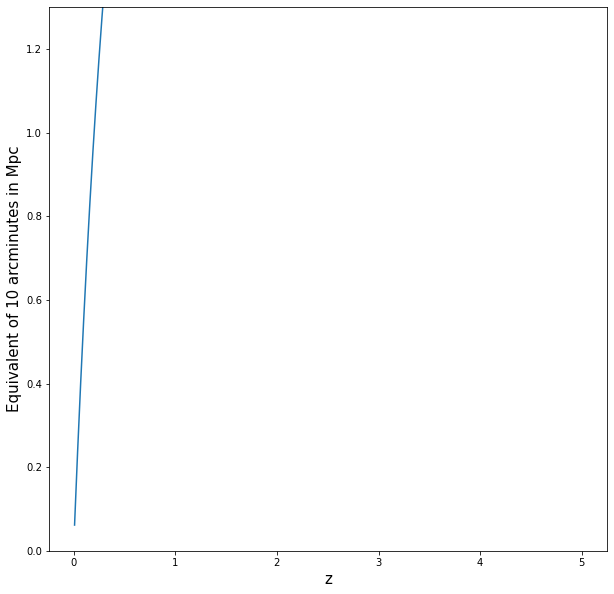

In [10]:
plt.figure(figsize = (10, 10))
plt.plot(z_array, ((np.pi/180)*(5/60))*(phys_ang(z_array)))
plt.ylim(0, 3)
plt.ylim(0, 1.3)
plt.xlabel("z", fontsize = 15)
plt.ylabel("Equivalent of 10 arcminutes in Mpc", fontsize = 15)

In [10]:
radius_threshold(1)*((180/np.pi)*60)

2.063641659468084

In [97]:
10/(radius_threshold(0.1)*((180/np.pi)*60))

1.1073496819979711